# Notebook to extract hidden-states and attention heads activations from bert model predictions

In [1]:
#transformers==3.1.0

In [2]:
transformers.__version__


NameError: name 'transformers' is not defined

In [3]:
import os
#import sys
#sys.path.append('/Volumes/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/src/lib')

import glob
import torch
import yaml
import gc
import uuid
import numpy as np
import pandas as pd
from tqdm import tqdm
from model import BertExtractor
from sklearn.preprocessing import StandardScaler
from tokenizer import tokenize
from bert_utils import set_seed
from numpy import linalg as la
import matplotlib.pyplot as plt
import bert_utils

In [4]:
def check_folder(path):
    """Create adequate folders if necessary."""
    try:
        if not os.path.isdir(path):
            check_folder(os.path.dirname(path))
            os.mkdir(path)
    except:
        pass

In [5]:
def transform(activations, path, name, run_index, n_layers_hidden=13, n_layers_attention=12, hidden_size=768):
    assert activations.values.shape[1] == (n_layers_hidden + n_layers_attention) * hidden_size
    indexes = [[index*hidden_size, (index+1)*hidden_size] for index in range(n_layers_hidden + n_layers_attention)]
    for order in [2]:
        matrices = []
        for i, index in enumerate(indexes):
            matrix = activations.values[:, index[0]:index[1]]
            #with_std = True if order=='std' else False
            #scaler = StandardScaler(with_mean=True, with_std=with_std)
            #scaler.fit(matrix)
            #matrix = scaler.transform(matrix)
            if order is not None and order != 'std':
                matrix = matrix / np.mean(la.norm(matrix, ord=order, axis=1))
            matrices.append(matrix)
        matrices = np.hstack(matrices)
        new_data = pd.DataFrame(matrices, columns=activations.columns)
        new_path = path + '_norm-' + str(order).replace('np.', '')
        check_folder(new_path)
        new_data.to_csv(os.path.join(new_path, name + '_run{}.csv'.format(run_index + 1)), index=False)


Defining variables:

In [6]:
template = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/text/english/text_english_run*.txt' # path to text input
language = 'english'

Creating iterator for each run:

In [5]:
template = '/Users/alexpsq/Code/Parietal/data/text_english_run*.txt' # path to text input


In [7]:
paths = sorted(glob.glob(template))

In [8]:
iterator_list = [tokenize(path, language, train=False) for path in paths]

100%|██████████| 207/207 [00:00<00:00, 262858.29it/s]


In [9]:
iterator_list

[['Once , when I was six years old , I saw a magnificent picture in a book about the primeval forest called ‘ Real - life Stories . ’',
  'It showed a boa constrictor swallowing a wild animal .',
  'Here is a copy of the drawing .',
  'It said in the book : “ Boa constrictors swallow their prey whole , without chewing .',
  'Then they are not able to move , and they sleep for the six months it takes for digestion . ”',
  'So I thought a lot about the adventures of the jungle and , in turn , I managed , with a coloured pencil , to make my first drawing .',
  'My Drawing Number one .',
  'It looked like this : I showed my masterpiece to the grownups and I asked them if my drawing frightened them .',
  'They answered me : “ Why would anyone be frightened by a hat ? ”',
  'My drawing was not of a hat .',
  'It showed a boa constrictor digesting an elephant .',
  'I then drew the inside of the boa constrictor , so that the grownups could understand .',
  'They always need to have things exp

In [10]:
iterator_list = [[sent.lower() for sent in text] for text in iterator_list]

In [11]:
iterator_list

[['once , when i was six years old , i saw a magnificent picture in a book about the primeval forest called ‘ real - life stories . ’',
  'it showed a boa constrictor swallowing a wild animal .',
  'here is a copy of the drawing .',
  'it said in the book : “ boa constrictors swallow their prey whole , without chewing .',
  'then they are not able to move , and they sleep for the six months it takes for digestion . ”',
  'so i thought a lot about the adventures of the jungle and , in turn , i managed , with a coloured pencil , to make my first drawing .',
  'my drawing number one .',
  'it looked like this : i showed my masterpiece to the grownups and i asked them if my drawing frightened them .',
  'they answered me : “ why would anyone be frightened by a hat ? ”',
  'my drawing was not of a hat .',
  'it showed a boa constrictor digesting an elephant .',
  'i then drew the inside of the boa constrictor , so that the grownups could understand .',
  'they always need to have things exp

In [10]:

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
for i in range(9):
    a = len(' '.join(iterator_list[i]).split())
    b = len(tokenizer.wordpiece_tokenizer.tokenize(' '.join(iterator_list[i])))
    print(f'run {i} ->', 100*(a-b)/b)

run 0 -> -4.48814926878467
run 1 -> -3.592814371257485
run 2 -> -2.0051194539249146
run 3 -> -3.3243486073674755
run 4 -> -2.6402640264026402
run 5 -> -3.1426269137792104
run 6 -> -1.4569000404694457
run 7 -> -1.688374336710082
run 8 -> -0.8232065856526852


In [12]:
import random 
sequence = 'once , when i was six years old , i saw a magnificent picture in a book about the primeval forest called ‘ real - life stories . ’'
print(tokenizer.wordpiece_tokenizer.tokenize(sequence))
len(shuffle_words(sequence, start_at=5))

['once', ',', 'when', 'i', 'was', 'six', 'years', 'old', ',', 'i', 'saw', 'a', 'magnificent', 'picture', 'in', 'a', 'book', 'about', 'the', 'prime', '##val', 'forest', 'called', '‘', 'real', '-', 'life', 'stories', '.', '’']


NameError: name 'shuffle_words' is not defined

In [ ]:
batch_tmp, index_tmp = shuffle_sentence_context(
    iterator_list[0][:2], 
    context_size=6, 
    pretrained_model='bert-base-uncased',
    seed=1111)
for b in batch_tmp:
    print(b)
    print()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # to replace with tokenizer of interest

for i, j in enumerate(batch_tmp):
    j  ='[CLS] ' + j + ' [SEP]'
    print(tokenizer.wordpiece_tokenizer.tokenize(j)[index_tmp[i][0]+1:1+index_tmp[i][1]])
#len(tokenizer.wordpiece_tokenizer.tokenize(' '.join(context[i]) + ' ' + ' '.join(words[:i+1])))



In [ ]:
import random
iterator_list[0][:3]

In [ ]:
batch_tmp, index_tmp = batchify_sentences(
    iterator_list[0][:3],
    'bert-base-uncased',
    1, 
    1, 
    0,
    10,
    transformation='shuffle',
    vocabulary=None,
    dictionary=None,
    seed=111
)
for i, j in enumerate(batch_tmp):
    #j  ='[CLS] ' + j + ' [SEP]'
    #print(index_tmp[i])
    #print(tokenizer.wordpiece_tokenizer.tokenize(j))
    print('##', i, ' - ', j)
    #print('##', i, ' - ', tokenizer.wordpiece_tokenizer.tokenize(j)[index_tmp[i][0]:index_tmp[i][1]])
    #print(tokenizer.wordpiece_tokenizer.tokenize(j)[1+index_tmp[i][0]:1+index_tmp[i][1]])
    #print()
    #print()
#print(batch_tmp[-2])
#print(batch_tmp[-1])

In [ ]:
batch_tmp

In [ ]:
l = [0,0,0,3, 4, 5]
l[len(l):len(l)]

In [ ]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#tokenizer.wordpiece_tokenizer.tokenize('he mustn ’ t bite you ...')

In [ ]:
#import utils
#import seaborn as sns
#import matplotlib.pyplot as plt
#from transformers import BertTokenizer
#
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#lengths = []
#
#for index in range(9):
#    batches, indexes = utils.batchify_per_sentence_with_pre_and_post_context(
#                iterator_list[index], 
#                1, 
#                12, 
#                0, 
#                'bert-base-uncased', 
#                max_length=512)
#    #lengths.append(np.array(sorted([len(item.split()) for item in batches])))
#    lengths.append(np.array(sorted([len(tokenizer.wordpiece_tokenizer.tokenize(item)) for item in batches])))
#
#    #sns.boxplot(lengths[-1])
#    #plt.show()
#    #print()
#
#print(np.mean(np.array([np.mean(item) for item in lengths])))
#print(np.median(np.array([np.median(item) for item in lengths])))
#print(np.mean(np.array([np.median(item) for item in lengths])))

In [ ]:
#import utils
#import seaborn as sns
#import matplotlib.pyplot as plt
#
#for index in range(9):
#    batches, indexes = utils.batchify_per_sentence_with_pre_and_post_context(
#                iterator_list[index], 
#                1, 
#                10, 
#                0, 
#                'bert-base-uncased', 
#                max_length=512)
#    #print(len(batches))
#    #print(sorted([len(item.split()) for item in batches]))
#    #sns.boxplot(sorted([len(item.split()) for item in batches]))
#    #plt.show()
#    #print()
#    indexes_tmp = []
#    for i in range(len(indexes)):
#        if type(indexes[i])==list and type(indexes[i][0])==list:
#            indexes_tmp.append(indexes[i][-1])
#        else:
#            if i > 0:
#                indexes_tmp.append((
#                indexes[i][-1-2][0], 
#                indexes[i][-1-2][1]))
#            else:
#                indexes_tmp.append(None)
#
#    indexes_tmp[0] = (indexes[0][0][0], indexes[0][-1][1])
#    print(indexes_tmp[0])

In [15]:
from transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained("../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer")


file ../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer/config.json not found


In [29]:
from transformers import BertTokenizer, BertModel, BertForPreTraining, BertForMaskedLM, WEIGHTS_NAME, CONFIG_NAME
from tokenizers import BertWordPieceTokenizer, Tokenizer

strip_accents = True
tokenizer_from_scratch = True
lowercase = True
vocab_size = 50001
min_frequency = 2
limit_alphabet = 1000
    
tokenizer_trained = BertWordPieceTokenizer( 
                        clean_text=True, 
                        handle_chinese_chars=False, 
                        strip_accents=strip_accents, 
                        lowercase=lowercase)
dataset_dir = "/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/text/english/all_training"
files = [os.path.join(dataset_dir, item) for item in ['bert_train.txt', 'bert_test.txt', 'bert_dev.txt']]
tokenizer_trained.train( 
                files, 
                vocab_size=vocab_size, 
                min_frequency=min_frequency, 
                show_progress=True, 
                special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"], 
                limit_alphabet=limit_alphabet, #1000 
                wordpieces_prefix="##")
tokenizer_trained.enable_truncation(max_length=512)

print(tokenizer_trained.encode("[CLS] [MASK] . [UNK] [SEP] [PAD]").ids) # --> [2, 4, 12, 1, 3, 0]


[2, 4, 18, 1, 3, 0]


In [43]:
tokenizer_trained

Tokenizer(vocabulary_size=50001, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=False, strip_accents=True, lowercase=True, wordpieces_prefix=##)

In [25]:
iterator = iterator_list[0]
for i, sentence in enumerate(iterator):
    print(i)
    sentence = "[CLS] [MASK] . [UNK] [SEP] [PAD]" # --> [2, 4, 12, 1, 3, 0]
    tokenized_text = tokenizer.wordpiece_tokenizer.tokenize(sentence)
    print(sentence, '-', tokenizer.encode(sentence), '-', tokenizer.convert_tokens_to_ids(tokenized_text))
    
    print()

0
[CLS] [MASK] . [UNK] [SEP] [PAD] - [2, 2, 4, 18, 1, 3, 0, 3] - [2, 4, 18, 1, 3, 0]

1
[CLS] [MASK] . [UNK] [SEP] [PAD] - [2, 2, 4, 18, 1, 3, 0, 3] - [2, 4, 18, 1, 3, 0]

2
[CLS] [MASK] . [UNK] [SEP] [PAD] - [2, 2, 4, 18, 1, 3, 0, 3] - [2, 4, 18, 1, 3, 0]

3
[CLS] [MASK] . [UNK] [SEP] [PAD] - [2, 2, 4, 18, 1, 3, 0, 3] - [2, 4, 18, 1, 3, 0]

4
[CLS] [MASK] . [UNK] [SEP] [PAD] - [2, 2, 4, 18, 1, 3, 0, 3] - [2, 4, 18, 1, 3, 0]

5
[CLS] [MASK] . [UNK] [SEP] [PAD] - [2, 2, 4, 18, 1, 3, 0, 3] - [2, 4, 18, 1, 3, 0]

6
[CLS] [MASK] . [UNK] [SEP] [PAD] - [2, 2, 4, 18, 1, 3, 0, 3] - [2, 4, 18, 1, 3, 0]

7
[CLS] [MASK] . [UNK] [SEP] [PAD] - [2, 2, 4, 18, 1, 3, 0, 3] - [2, 4, 18, 1, 3, 0]

8
[CLS] [MASK] . [UNK] [SEP] [PAD] - [2, 2, 4, 18, 1, 3, 0, 3] - [2, 4, 18, 1, 3, 0]

9
[CLS] [MASK] . [UNK] [SEP] [PAD] - [2, 2, 4, 18, 1, 3, 0, 3] - [2, 4, 18, 1, 3, 0]

10
[CLS] [MASK] . [UNK] [SEP] [PAD] - [2, 2, 4, 18, 1, 3, 0, 3] - [2, 4, 18, 1, 3, 0]

11
[CLS] [MASK] . [UNK] [SEP] [PAD] - [2, 2, 4, 18, 1

In [23]:
vars(tokenizer)

{'init_inputs': (),
 'init_kwargs': {'do_lower_case': True,
  'do_basic_tokenize': True,
  'never_split': None,
  'unk_token': '[UNK]',
  'sep_token': '[SEP]',
  'pad_token': '[PAD]',
  'cls_token': '[CLS]',
  'mask_token': '[MASK]',
  'tokenize_chinese_chars': True,
  'strip_accents': None,
  'special_tokens_map_file': None,
  'tokenizer_file': '../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer/tokenizer.json',
  'name_or_path': '../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer'},
 'name_or_path': '../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer',
 'model_max_length': 1000000000000000019884624838656,
 'padding_side': 'right',
 'model_input_names': ['input_ids', 'token_type_ids', 'attention_mask'],
 'deprecation_warnings': {},
 '_bos_token': None,
 '_eos_token': None,
 '_unk_token': '[UNK]',
 '_sep_token': '[SEP]',
 '_pad_token': '[PAD]',
 '_cls_token': '[CLS]',
 '

## Activation extraction

In [12]:
pretrained_bert_models = [
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/end-epoch-0",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/end-epoch-1",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/end-epoch-2",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/end-epoch-3",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/end-epoch-4",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/end-epoch-5",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/end-epoch-6",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/end-epoch-7",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/end-epoch-8",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/end-epoch-9",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/end-epoch-10",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/end-epoch-11",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/end-epoch-12",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/end-epoch-13",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/end-epoch-14",

"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/end-epoch-0",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/end-epoch-1",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/end-epoch-2",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/end-epoch-3",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/end-epoch-4",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/end-epoch-5",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/end-epoch-6",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/end-epoch-7",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/end-epoch-8",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/end-epoch-9",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/end-epoch-10",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/end-epoch-11",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/end-epoch-12",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/end-epoch-13",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/end-epoch-14",
    
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/end-epoch-0",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/end-epoch-1",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/end-epoch-2",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/end-epoch-3",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/end-epoch-4",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/end-epoch-5",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/end-epoch-6",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/end-epoch-7",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/end-epoch-8",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/end-epoch-9",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/end-epoch-10",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/end-epoch-11",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/end-epoch-12",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/end-epoch-13",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/end-epoch-14",


]
pretrained_bert_tokenizer_list = [
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/bert_tokenizer",
"../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/bert_tokenizer",

    
]
names = [
"bert_L-1_H-768_trained_pre-20_1_end-epoch-0",
"bert_L-1_H-768_trained_pre-20_1_end-epoch-1",
"bert_L-1_H-768_trained_pre-20_1_end-epoch-2",
"bert_L-1_H-768_trained_pre-20_1_end-epoch-3",
"bert_L-1_H-768_trained_pre-20_1_end-epoch-4",
"bert_L-1_H-768_trained_pre-20_1_end-epoch-5",
"bert_L-1_H-768_trained_pre-20_1_end-epoch-6",
"bert_L-1_H-768_trained_pre-20_1_end-epoch-7",
"bert_L-1_H-768_trained_pre-20_1_end-epoch-8",
"bert_L-1_H-768_trained_pre-20_1_end-epoch-9",
"bert_L-1_H-768_trained_pre-20_1_end-epoch-10",
"bert_L-1_H-768_trained_pre-20_1_end-epoch-11",
"bert_L-1_H-768_trained_pre-20_1_end-epoch-12",
"bert_L-1_H-768_trained_pre-20_1_end-epoch-13",
"bert_L-1_H-768_trained_pre-20_1_end-epoch-14",
"bert_L-2_H-768_trained_pre-20_1_end-epoch-0",
"bert_L-2_H-768_trained_pre-20_1_end-epoch-1",
"bert_L-2_H-768_trained_pre-20_1_end-epoch-2",
"bert_L-2_H-768_trained_pre-20_1_end-epoch-3",
"bert_L-2_H-768_trained_pre-20_1_end-epoch-4",
"bert_L-2_H-768_trained_pre-20_1_end-epoch-5",
"bert_L-2_H-768_trained_pre-20_1_end-epoch-6",
"bert_L-2_H-768_trained_pre-20_1_end-epoch-7",
"bert_L-2_H-768_trained_pre-20_1_end-epoch-8",
"bert_L-2_H-768_trained_pre-20_1_end-epoch-9",
"bert_L-2_H-768_trained_pre-20_1_end-epoch-10",
"bert_L-2_H-768_trained_pre-20_1_end-epoch-11",
"bert_L-2_H-768_trained_pre-20_1_end-epoch-12",
"bert_L-2_H-768_trained_pre-20_1_end-epoch-13",
"bert_L-2_H-768_trained_pre-20_1_end-epoch-14",
"bert_L-4_H-768_trained_pre-20_1_end-epoch-0",
"bert_L-4_H-768_trained_pre-20_1_end-epoch-1",
"bert_L-4_H-768_trained_pre-20_1_end-epoch-2",
"bert_L-4_H-768_trained_pre-20_1_end-epoch-3",
"bert_L-4_H-768_trained_pre-20_1_end-epoch-4",
"bert_L-4_H-768_trained_pre-20_1_end-epoch-5",
"bert_L-4_H-768_trained_pre-20_1_end-epoch-6",
"bert_L-4_H-768_trained_pre-20_1_end-epoch-7",
"bert_L-4_H-768_trained_pre-20_1_end-epoch-8",
"bert_L-4_H-768_trained_pre-20_1_end-epoch-9",
"bert_L-4_H-768_trained_pre-20_1_end-epoch-10",
"bert_L-4_H-768_trained_pre-20_1_end-epoch-11",
"bert_L-4_H-768_trained_pre-20_1_end-epoch-12",
"bert_L-4_H-768_trained_pre-20_1_end-epoch-13",
"bert_L-4_H-768_trained_pre-20_1_end-epoch-14",
         ]
config_paths = pretrained_bert_models # [None] * 34
saving_path_folders = [
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-1_H-768_trained_pre-20_1_end-epoch-0".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-1_H-768_trained_pre-20_1_end-epoch-1".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-1_H-768_trained_pre-20_1_end-epoch-2".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-1_H-768_trained_pre-20_1_end-epoch-3".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-1_H-768_trained_pre-20_1_end-epoch-4".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-1_H-768_trained_pre-20_1_end-epoch-5".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-1_H-768_trained_pre-20_1_end-epoch-6".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-1_H-768_trained_pre-20_1_end-epoch-7".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-1_H-768_trained_pre-20_1_end-epoch-8".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-1_H-768_trained_pre-20_1_end-epoch-9".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-1_H-768_trained_pre-20_1_end-epoch-10".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-1_H-768_trained_pre-20_1_end-epoch-11".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-1_H-768_trained_pre-20_1_end-epoch-12".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-1_H-768_trained_pre-20_1_end-epoch-13".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-1_H-768_trained_pre-20_1_end-epoch-14".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-2_H-768_trained_pre-20_1_end-epoch-0".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-2_H-768_trained_pre-20_1_end-epoch-1".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-2_H-768_trained_pre-20_1_end-epoch-2".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-2_H-768_trained_pre-20_1_end-epoch-3".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-2_H-768_trained_pre-20_1_end-epoch-4".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-2_H-768_trained_pre-20_1_end-epoch-5".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-2_H-768_trained_pre-20_1_end-epoch-6".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-2_H-768_trained_pre-20_1_end-epoch-7".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-2_H-768_trained_pre-20_1_end-epoch-8".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-2_H-768_trained_pre-20_1_end-epoch-9".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-2_H-768_trained_pre-20_1_end-epoch-10".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-2_H-768_trained_pre-20_1_end-epoch-11".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-2_H-768_trained_pre-20_1_end-epoch-12".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-2_H-768_trained_pre-20_1_end-epoch-13".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-2_H-768_trained_pre-20_1_end-epoch-14".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-4_H-768_trained_pre-20_1_end-epoch-0".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-4_H-768_trained_pre-20_1_end-epoch-1".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-4_H-768_trained_pre-20_1_end-epoch-2".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-4_H-768_trained_pre-20_1_end-epoch-3".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-4_H-768_trained_pre-20_1_end-epoch-4".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-4_H-768_trained_pre-20_1_end-epoch-5".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-4_H-768_trained_pre-20_1_end-epoch-6".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-4_H-768_trained_pre-20_1_end-epoch-7".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-4_H-768_trained_pre-20_1_end-epoch-8".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-4_H-768_trained_pre-20_1_end-epoch-9".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-4_H-768_trained_pre-20_1_end-epoch-10".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-4_H-768_trained_pre-20_1_end-epoch-11".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-4_H-768_trained_pre-20_1_end-epoch-12".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-4_H-768_trained_pre-20_1_end-epoch-13".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert_L-4_H-768_trained_pre-20_1_end-epoch-14".format(language),
    #'gpt2_L-4_H-768_trained_pre-20_1',
]

assert len(pretrained_bert_models)==len(pretrained_bert_tokenizer_list)
assert len(pretrained_bert_tokenizer_list)==len(names)
assert len(pretrained_bert_tokenizer_list)==len(saving_path_folders)

prediction_types = ['sentence'] * len(pretrained_bert_models)
number_of_sentence_list = [1] * len(pretrained_bert_models)
number_of_sentence_before_list = [20] * len(pretrained_bert_models)
number_of_sentence_after_list = [0] * len(pretrained_bert_models)
attention_length_before_list = [1000] * len(pretrained_bert_models)
attention_length_after_list = [1000] * len(pretrained_bert_models)
n_layers_hidden_list = [1] * 15 + [2] * 15 + [4] * 15
hidden_size_list = [768] * len(pretrained_bert_models)


stop_attention_at_sent_before_list = [None] * len(pretrained_bert_models)
stop_attention_before_sent_list = [0] * len(pretrained_bert_models)


In [12]:
pretrained_bert_models = [
    "../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/started_at_21_fine_tuned",
    "../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/started_at_24_fine_tuned",
    "../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/started_at_21_fine_tuned",
]
pretrained_bert_tokenizer_list = [
    "../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-1_H-768/bert_tokenizer",
    "../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-2_H-768/bert_tokenizer",
    "../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/bert_tokenizer",
]
names = [
    'bert-base-uncased_L-1_H-768_trained_15-epochs_pre-20_1_post-0',
    'bert-base-uncased_L-2_H-768_trained_15-epochs_pre-20_1_post-0',
    'bert-base-uncased_L-4_H-768_trained_15-epochs_pre-20_1_post-0',
         ]
config_paths = pretrained_bert_models # [None] * 34
saving_path_folders = [
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_L-1_H-768_trained_15-epochs_pre-20_1_post-0'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_L-2_H-768_trained_15-epochs_pre-20_1_post-0'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_L-4_H-768_trained_15-epochs_pre-20_1_post-0'.format(language),
    
]
prediction_types = ['sentence'] * 34
number_of_sentence_list = [1] * 34
number_of_sentence_before_list = [20] * 34
number_of_sentence_after_list = [0] * 21
attention_length_before_list = [1000] * 34
attention_length_after_list = [1000] * 34
n_layers_hidden_list = [1, 2, 4]
hidden_size_list = [768] * 34

stop_attention_at_sent_before_list = [None] * 34
stop_attention_before_sent_list = [0] * 34


In [ ]:
for index, bert_model in enumerate(pretrained_bert_models):
    extractor = BertExtractor(bert_model, 
                              language, 
                              names[index], 
                              prediction_types[index], 
                              output_hidden_states=True, 
                              output_attentions=False, 
                              attention_length_before=attention_length_before_list[index],
                              attention_length_after=attention_length_after_list[index],
                              config_path=config_paths[index], 
                              max_length=512,
                              randomize=False,
                              number_of_sentence=number_of_sentence_list[index], 
                              number_of_sentence_before=number_of_sentence_before_list[index], 
                              number_of_sentence_after=number_of_sentence_after_list[index],
                              stop_attention_at_sent_before=stop_attention_at_sent_before_list[index],
                              stop_attention_before_sent=stop_attention_before_sent_list[index],
                              pretrained_bert_tokenizer=pretrained_bert_tokenizer_list[index]
                             )
    print(extractor.name, ' - Extracting activations ...')
    for run_index, iterator in tqdm(enumerate(iterator_list)):
        gc.collect()
        print("############# Run {} #############".format(run_index))
        activations  = extractor.extract_activations(iterator, language)
        hidden_states_activations = activations[0]
        #attention_heads_activations = activations[1]
        #(cls_hidden_states_activations, cls_attention_activations) = activations[2]
        #(sep_hidden_states_activations, sep_attention_activations) = activations[3]
        #activations = pd.concat([hidden_states_activations, attention_heads_activations], axis=1)
        #cls_activations = pd.concat([cls_hidden_states_activations, cls_attention_activations], axis=1)
        #sep_activations = pd.concat([sep_hidden_states_activations, sep_attention_activations], axis=1)

        transform(
            hidden_states_activations, 
            saving_path_folders[index], 
            'activations', 
            run_index=run_index,
            n_layers_hidden=n_layers_hidden_list[index]+1,
            n_layers_attention=0, 
            hidden_size=hidden_size_list[index])

        #transform(cls_activations, saving_path_folders[index], 'cls')
        #transform(sep_activations, saving_path_folders[index], 'sep')
        #check_folder(saving_path_folders[index])
        #hidden_states_activations.to_csv(os.path.join(saving_path_folders[index], 'activations_run{}.csv'.format(run_index + 1)), index=False)
        #cls_activations.to_csv(os.path.join(saving_path_folders[index], 'cls_run{}.csv'.format(run_index + 1)), index=False)
        #sep_activations.to_csv(os.path.join(saving_path_folders[index], 'sep_run{}.csv'.format(run_index + 1)), index=False)
        del activations
        #del cls_activations
        #del sep_activations
        del hidden_states_activations
        #del attention_heads_activations
        #del cls_hidden_states_activations
        #del cls_attention_activations
        #del sep_hidden_states_activations
        #del sep_attention_activations


### Generate control activations

In [14]:
bert_model = 'bert-base-cased'
language = 'english'
name = 'bert-base-cased_control_'
prediction_type = 'sentence'
saving_path_folder = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}'.format(language)
seeds = [24, 213, 1111, 61, 183]

In [ ]:
def randomize_layer(model, layer_nb):
    """Randomize layer weights and put bias to zero.
    The input "layer_nb" goes from 1 to 12 to be coherent with the rest of the analysis.
    It is then transfomed in the function.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].attention.self.query.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.self.query.weight))
    model.encoder.layer[layer_nb].attention.self.query.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.self.query.bias))
    model.encoder.layer[layer_nb].attention.self.key.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.self.key.weight))
    model.encoder.layer[layer_nb].attention.self.key.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.self.key.bias))
    model.encoder.layer[layer_nb].attention.self.value.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.self.value.weight))
    model.encoder.layer[layer_nb].attention.self.value.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.self.value.bias))
    model.encoder.layer[layer_nb].attention.output.dense.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.output.dense.weight))
    model.encoder.layer[layer_nb].attention.output.dense.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.output.dense.bias))
    model.encoder.layer[layer_nb].attention.output.LayerNorm.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.output.LayerNorm.weight))
    model.encoder.layer[layer_nb].attention.output.LayerNorm.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.output.LayerNorm.bias))
    model.encoder.layer[layer_nb].intermediate.dense.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].intermediate.dense.weight))
    model.encoder.layer[layer_nb].intermediate.dense.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].intermediate.dense.bias))
    model.encoder.layer[layer_nb].output.dense.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].output.dense.weight))
    model.encoder.layer[layer_nb].output.dense.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].output.dense.bias))
    model.encoder.layer[layer_nb].output.LayerNorm.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].output.LayerNorm.weight))
    model.encoder.layer[layer_nb].output.LayerNorm.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].output.LayerNorm.bias))
    return model

In [ ]:
def randomize_attention_query(model, layer_nb):
    """Randomize attention query weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].attention.self.query.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.self.query.weight))
    model.encoder.layer[layer_nb].attention.self.query.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.self.query.bias))
    return model

def randomize_attention_key(model, layer_nb):
    """Randomize attention key weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].attention.self.key.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.self.key.weight))
    model.encoder.layer[layer_nb].attention.self.key.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.self.key.bias))
    return model

def randomize_attention_value(model, layer_nb):
    """Randomize attention value weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].attention.self.value.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.self.value.weight))
    model.encoder.layer[layer_nb].attention.self.value.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.self.value.bias))
    return model

def randomize_attention_output_dense(model, layer_nb):
    """Randomize attention dense network weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].attention.output.dense.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.output.dense.weight))
    model.encoder.layer[layer_nb].attention.output.dense.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.output.dense.bias))
    return model


def randomize_intermediate_dense(model, layer_nb):
    """Randomize intermediate dense network weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].intermediate.dense.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].intermediate.dense.weight))
    model.encoder.layer[layer_nb].intermediate.dense.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].intermediate.dense.bias))
    return model

def randomize_outptut_dense(model, layer_nb):
    """Randomize output dense network weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].output.dense.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].output.dense.weight))
    model.encoder.layer[layer_nb].output.dense.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].output.dense.bias))
    return model


In [ ]:
def randomize_embeddings(model):
    """Randomize embeddings weights and put bias to zero.
    """
    model.embeddings.word_embeddings.weight = torch.nn.parameter.Parameter(torch.rand_like(model.embeddings.word_embeddings.weight))
    model.embeddings.position_embeddings.weight = torch.nn.parameter.Parameter(torch.rand_like(model.embeddings.position_embeddings.weight))
    model.embeddings.token_type_embeddings.weight = torch.nn.parameter.Parameter(torch.rand_like(model.embeddings.token_type_embeddings.weight))
    model.embeddings.LayerNorm.weight = torch.nn.parameter.Parameter(torch.rand_like(model.embeddings.LayerNorm.weight))
    model.embeddings.LayerNorm.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.embeddings.LayerNorm.bias))
    return model

In [ ]:
for seed in seeds:
    set_seed(seed)
    for layer in range(13):
        extractor = BertExtractor(bert_model, language, name, prediction_type, output_hidden_states=True, output_attentions=True, config_path=None)
        if layer==0:
            extractor.model = randomize_embeddings(extractor.model)
        else:
            extractor.model = randomize_layer(extractor.model, layer)
        print(extractor.name + str(seed), ' - Extracting activations for layer {}...'.format(layer))
        for run_index, iterator in tqdm(enumerate(iterator_list)):
            print("############# Run {} #############".format(run_index))
            activations  = extractor.extract_activations(iterator, language)
            hidden_states_activations = activations[0]
            attention_heads_activations = activations[1]
            (cls_hidden_states_activations, cls_attention_activations) = activations[2]
            (sep_hidden_states_activations, sep_attention_activations) = activations[3]
            activations = pd.concat([hidden_states_activations, attention_heads_activations], axis=1)
            cls_activations = pd.concat([cls_hidden_states_activations, cls_attention_activations], axis=1)
            sep_activations = pd.concat([sep_hidden_states_activations, sep_attention_activations], axis=1)

            # activations
            heads = np.arange(1, 13)
            columns_to_retrieve = ['hidden_state-layer-{}-{}'.format(layer, i) for i in range(1, 769)]
            if layer > 0:
                columns_to_retrieve += ['attention-layer-{}-head-{}-{}'.format(layer, head, i) for head in heads for i in range(1, 65)]
            activations = activations[columns_to_retrieve]

            # CLS
            heads = np.arange(1, 13)
            columns_to_retrieve = ['CLS-hidden_state-layer-{}-{}'.format(layer, i) for i in range(1, 769)]
            if layer > 0:
                columns_to_retrieve += ['CLS-attention-layer-{}-head-{}-{}'.format(layer, head, i) for head in heads for i in range(1, 65)]
            cls_activations = cls_activations[columns_to_retrieve]

            # SEP
            heads = np.arange(1, 13)
            columns_to_retrieve = ['SEP-hidden_state-layer-{}-{}'.format(layer, i) for i in range(1, 769)]
            if layer > 0:
                columns_to_retrieve += ['SEP-attention-layer-{}-head-{}-{}'.format(layer, head, i) for head in heads for i in range(1, 65)]
            sep_activations = sep_activations[columns_to_retrieve]

            save_path = os.path.join(saving_path_folder, name + str(seed) + '_layer-{}'.format(layer))
            check_folder(save_path)
            print('\tSaving in {}.'.format(save_path))
            activations.to_csv(os.path.join(save_path, 'activations_run{}.csv'.format(run_index + 1)), index=False)
            cls_activations.to_csv(os.path.join(save_path, 'cls_run{}.csv'.format(run_index + 1)), index=False)
            sep_activations.to_csv(os.path.join(save_path, 'sep_run{}.csv'.format(run_index + 1)), index=False)


In [29]:
import utils 
import random
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
model.encoder.layer[3].output.dense.weight

Parameter containing:
tensor([[-0.0175, -0.0093,  0.0379,  ...,  0.0424,  0.0227, -0.0133],
        [ 0.0163, -0.0708,  0.0160,  ..., -0.0395,  0.0004, -0.0208],
        [-0.0266, -0.0686,  0.0257,  ...,  0.0036, -0.0068, -0.0047],
        ...,
        [ 0.0887,  0.0234,  0.0554,  ..., -0.0025, -0.0587, -0.0505],
        [ 0.0172, -0.0138,  0.0026,  ..., -0.0148,  0.0112, -0.0099],
        [ 0.0393, -0.0084,  0.0155,  ..., -0.0479,  0.0550, -0.0122]],
       requires_grad=True)

In [31]:
def randomize_model(model):
    for module_ in model.named_modules(): 
        if isinstance(module_[1],(torch.nn.Linear, torch.nn.Embedding)):
            module_[1].weight.data.normal_(mean=0.0, std=model.config.initializer_range)
        elif isinstance(module_[1], torch.nn.LayerNorm):
            module_[1].bias.data.zero_()
            module_[1].weight.data.fill_(1.0)
        if isinstance(module_[1], torch.nn.Linear) and module_[1].bias is not None:
            module_[1].bias.data.zero_()
    return model

In [32]:
model2 = randomize_model(model)
print(model.encoder.layer[3].output.dense.weight)
print(model2.encoder.layer[3].output.dense.weight)

Parameter containing:
tensor([[-0.0217, -0.0181, -0.0069,  ...,  0.0207, -0.0227,  0.0107],
        [ 0.0275,  0.0005, -0.0092,  ...,  0.0249,  0.0157, -0.0216],
        [ 0.0143, -0.0416,  0.0198,  ...,  0.0467,  0.0154, -0.0008],
        ...,
        [-0.0324,  0.0041, -0.0183,  ...,  0.0203,  0.0297, -0.0159],
        [ 0.0296,  0.0095, -0.0236,  ..., -0.0266,  0.0010,  0.0283],
        [-0.0218,  0.0154,  0.0008,  ..., -0.0007,  0.0190, -0.0165]],
       requires_grad=True)
Parameter containing:
tensor([[-0.0217, -0.0181, -0.0069,  ...,  0.0207, -0.0227,  0.0107],
        [ 0.0275,  0.0005, -0.0092,  ...,  0.0249,  0.0157, -0.0216],
        [ 0.0143, -0.0416,  0.0198,  ...,  0.0467,  0.0154, -0.0008],
        ...,
        [-0.0324,  0.0041, -0.0183,  ...,  0.0203,  0.0297, -0.0159],
        [ 0.0296,  0.0095, -0.0236,  ..., -0.0266,  0.0010,  0.0283],
        [-0.0218,  0.0154,  0.0008,  ..., -0.0007,  0.0190, -0.0165]],
       requires_grad=True)


# Test activation extraction 

In [12]:
import utils 
import random
from transformers import BertTokenizer

config = {
    'number_of_sentence': 1, 
    'number_of_sentence_before': 10, 
    'number_of_sentence_after': 0, 
    'attention_length_before': 1000, 
    'attention_length_after': 1000,
}



tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
extractor_full = BertExtractor('bert-base-uncased', 
                              'english', 
                              'test', 
                              'sentence', 
                              output_hidden_states=True, 
                              output_attentions=True, 
                              attention_length_before=config['attention_length_before'],
                              attention_length_after=config['attention_length_after'],
                              config_path=None, 
                              number_of_sentence=config['number_of_sentence'], 
                              number_of_sentence_before=config['number_of_sentence_before'], 
                              number_of_sentence_after=config['number_of_sentence_after'], 
                             )
extractor_masked = BertExtractor('bert-base-uncased', 
                              'english', 
                              'test', 
                              'control-context', 
                              output_hidden_states=True, 
                              output_attentions=False, 
                              attention_length_before=config['attention_length_before'],
                              attention_length_after=config['attention_length_after'],
                              config_path=None, 
                              number_of_sentence=config['number_of_sentence'], 
                              number_of_sentence_before=config['number_of_sentence_before'], 
                              number_of_sentence_after=config['number_of_sentence_after'], 
                             )
#extractor_shuffle = BertExtractor('bert-base-uncased', 
#                              'english', 
#                              'test', 
#                              'shuffle', 
#                              output_hidden_states=True, 
#                              output_attentions=False, 
#                              attention_length_before=config['attention_length_before'],
#                              attention_length_after=config['attention_length_after'],
#                              config_path=None, 
#                              number_of_sentence=config['number_of_sentence'], 
#                              number_of_sentence_before=config['number_of_sentence_before'], 
#                              number_of_sentence_after=config['number_of_sentence_after'], 
#                             )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 

In [13]:
# Full sentences
batches_full, indexes_full = bert_utils.batchify_per_sentence_with_pre_and_post_context(
            iterator_list[0], 
            config['number_of_sentence'], 
            config['number_of_sentence_before'], 
            config['number_of_sentence_after'], 
            'bert-base-uncased',
        )

# Tokens are masked
batches_masked, indexes_masked = bert_utils.batchify_per_sentence_with_pre_and_post_context(
            iterator_list[0], 
            config['number_of_sentence'], 
            config['number_of_sentence_before'], 
            config['number_of_sentence_after'], 
            'bert-base-uncased', 
            )

## Shuffling
#batches_shuffle, indexes_shuffle = bert_utils.batchify_sentences(
#            iterator_list[0], 
#            config['number_of_sentence'], 
#            config['number_of_sentence_before'], 
#            config['number_of_sentence_after'], 
#            pretrained_model='bert-base-uncased', 
#            past_context_size=config['attention_length_before'],
#            future_context_size=config['attention_length_after'],
#            transformation='shuffle',
#            vocabulary=None,
#            dictionary=None,
#            seed=1111,
#            )

In [56]:
index = 7
batch = batches_masked[index]
print(batch)
batch = batch.strip() # Remove trailing character
batch = '[CLS] ' + batch + ' [SEP]'
tokenized_text = tokenizer.wordpiece_tokenizer.tokenize(batch)
print(indexes_masked[index])
attention_mask = torch.tensor([[1 for x in tokenized_text]])
print(attention_mask)
attention_mask[0, :1 + indexes_masked[index][0][-3:][0][0]] = 0
print(attention_mask[0, :].numpy().astype(int))
for j, i in enumerate(attention_mask[0, :].numpy().astype(bool)):
    if i>0:
        print(tokenized_text[j])

once , when i was six years old , i saw a magnificent picture in a book about the primeval forest called ‘ real - life stories . ’ it showed a boa constrictor swallowing a wild animal . here is a copy of the drawing . it said in the book : “ boa constrictors swallow their prey whole , without chewing . then they are not able to move , and they sleep for the six months it takes for digestion . ” so i thought a lot about the adventures of the jungle and , in turn , i managed , with a coloured pencil , to make my first drawing . my drawing number one . it looked like this : i showed my masterpiece to the grownups and i asked them if my drawing frightened them .
[[(0, 30), (30, 44), (44, 52), (52, 73), (73, 95), (95, 125), (125, 130), (130, 153)], (130, 153)]
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [61]:
attention_mask =  torch.tensor([[1 for x in tokenized_text] for i in range(indexes_masked[index][-1][0], indexes_masked[index][-1][-1])])
attention_mask

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

In [60]:
tokenized_text

['[CLS]',
 'once',
 ',',
 'when',
 'i',
 'was',
 'six',
 'years',
 'old',
 ',',
 'i',
 'saw',
 'a',
 'magnificent',
 'picture',
 'in',
 'a',
 'book',
 'about',
 'the',
 'prime',
 '##val',
 'forest',
 'called',
 '‘',
 'real',
 '-',
 'life',
 'stories',
 '.',
 '’',
 'it',
 'showed',
 'a',
 'bo',
 '##a',
 'con',
 '##st',
 '##ric',
 '##tor',
 'swallowing',
 'a',
 'wild',
 'animal',
 '.',
 'here',
 'is',
 'a',
 'copy',
 'of',
 'the',
 'drawing',
 '.',
 'it',
 'said',
 'in',
 'the',
 'book',
 ':',
 '“',
 'bo',
 '##a',
 'con',
 '##st',
 '##ric',
 '##tors',
 'swallow',
 'their',
 'prey',
 'whole',
 ',',
 'without',
 'chewing',
 '.',
 'then',
 'they',
 'are',
 'not',
 'able',
 'to',
 'move',
 ',',
 'and',
 'they',
 'sleep',
 'for',
 'the',
 'six',
 'months',
 'it',
 'takes',
 'for',
 'digest',
 '##ion',
 '.',
 '”',
 'so',
 'i',
 'thought',
 'a',
 'lot',
 'about',
 'the',
 'adventures',
 'of',
 'the',
 'jungle',
 'and',
 ',',
 'in',
 'turn',
 ',',
 'i',
 'managed',
 ',',
 'with',
 'a',
 'coloure

In [136]:
import bert_utils

batch = batches_masked[0]
batch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 


In [40]:
syntax = __import__('04_syntax_generator')
nlp = syntax.set_nlp_pipeline()
nlp = syntax.add_constituent_parser(nlp)
doc = nlp(batch)
sent = list(doc.sents)[0]
print(sent._.parse_string)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']
(S (ADVP (RB once)) (, ,) (SBAR (WHADVP (WRB when)) (S (NP (PRP i)) (VP (VBD was) (ADJP (NP (CD six) (NNS years)) (JJ old))))) (, ,) (NP (PRP i)) (VP (VBD saw) (NP (NP (DT a) (JJ magnificent) (NN picture)) (PP (IN in) (NP (NP (NP (DT a) (NN book)) (PP (IN about) (NP (DT the) (JJ primeval) (NN forest)))) (VP (VBN called) (S (`` ‘) (NP (JJ real) (: -) (NN life) (NNS stories)))))))) (. .) ('' ’))


In [52]:
batch = batches_masked[30]
tokenized_text = tokenizer.wordpiece_tokenizer.tokenize(batch)
inputs_ids = torch.tensor([tokenizer.convert_tokens_to_ids(tokenized_text)])
inputs_ids = torch.cat(inputs_ids.size(1) * [inputs_ids])
mapping = bert_utils.match_tokenized_to_untokenized(tokenized_text, batch)
batch

"i wanted to know if they were really a person of true understanding . but they always responded : “ it ' s a hat . ” so i would never speak to them of boa constrictors , nor of primeval forests , nor of the stars . i put myself at their level ."

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']
torch.Size([46, 46])


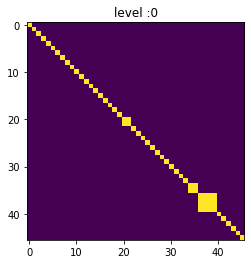

KeyboardInterrupt: 

In [56]:
from matplotlib import pyplot as plt

for i in [0, 1, 2, 3, 4, 5]:
    constituent_parsing_list = bert_utils.get_constituent_parsing_list(batch, level=i, skip_punctuation=True, incremental=False)
    attention_mask = create_attention_mask(tokenized_text, mapping, constituent_parsing_list, constituent_parsing_level=i)
    print(torch.tensor(attention_mask).size())

    
    plt.imshow(attention_mask)
    plt.title(f'level :{i}')
    plt.show()


In [14]:
def create_attention_mask(tokenized_text, mapping, index_list, constituent_parsing_level=1):
    """Create the attention mask associated with the input tokenized text for a given level 
    in the constituent parsing tree.
    Args:
        - tokenized_text: list of int
        - mapping: dict (resulting from match_tokenized_to_untokenized)
        - index_list: list (of list of int) e.g.: [[0, 1], [2], [2, 3]]
        - constituent_parsing_level: int (number of levels to consider in the constituent parsing tree)
    Returns:
        - attention_mask: nd.array (dim 2)
    """
    n = len(tokenized_text)
    attention_mask = np.zeros((n, n))
    for j, key in enumerate(mapping.keys()):
        for i, v in enumerate(index_list):
            if j in v:
                for token_i in mapping[i]:
                    for token_j in mapping[j]:
                        attention_mask[token_i, token_j] = 1
    return attention_mask

def get_constituent_parsing_list(text, level=1, skip_punctuation=True, incremental=False):
    """Retrieve the list of words index to which each word in the input text should pay attention too
    based on the constituent parsing tree and the defined level.
    Args:
        - text: str
        - level: int, level in the parsing tree
        - skip_punctuation: bool, do not touch punctuation
        - incremental: bool, masking relations with future words
    Returns:
        - constituent_parsing_list: list (of list of int)
    """
    nlp = syntax.set_nlp_pipeline()
    nlp = syntax.add_constituent_parser(nlp)
    constituent_parsing_list = syntax.constituent_parsing_at_level(text, nlp, level=level, skip_punctuation=skip_punctuation, incremental=incremental)
    return constituent_parsing_list

In [15]:
# Preprocessing full
indexes_full_tmp = []
for i in range(len(indexes_full)):
    if type(indexes_full[i])==list and type(indexes_full[i][0])==list:
        indexes_full_tmp.append(indexes_full[i][-1])
    else:
        if i > 0:
            indexes_full_tmp.append((
            indexes_full[i][-config['number_of_sentence']-config['number_of_sentence_after']][0], 
            indexes_full[i][-config['number_of_sentence']-config['number_of_sentence_after']][1]))
        else:
            indexes_full_tmp.append(None)


            
# Preprocessing masked
indexes_masked_tmp = []
# If beginning and end indexes of each sentences are recorded, we only keep the sentence(s) of interest
for i in range(len(indexes_masked)):
    if type(indexes_masked[i])==list and type(indexes_masked[i][0])==list:
        indexes_masked_tmp.append(indexes_masked[i][-1])
    else:
        if i > 0:
            indexes_masked_tmp.append((
            indexes_masked[i][-config['number_of_sentence']-config['number_of_sentence_after']][0], 
            indexes_masked[i][-config['number_of_sentence']-config['number_of_sentence_after']][1]))
        else:
            indexes_masked_tmp.append(None)

#if config['number_of_sentence_before']==0:
#    indexes_masked_tmp[0] = (indexes_masked[0][0][0][0], indexes_masked[0][-1][1])
#else:
#    indexes_masked_tmp[0] = (indexes_masked[0][0][0], indexes_masked[0][-1][1])


# Preprocessing shuffle




In [16]:
# activation generation full
output = []
attention_weights = []

for index, batch in enumerate(batches_full):
    batch = batch.strip() # Remove trailing character

    batch = '[CLS] ' + batch + ' [SEP]'
    tokenized_text = tokenizer.wordpiece_tokenizer.tokenize(batch)
    inputs_ids = torch.tensor([tokenizer.convert_tokens_to_ids(tokenized_text)])
    mapping = bert_utils.match_tokenized_to_untokenized(tokenized_text, batch)
    #print(mapping)

    attention_mask = torch.tensor([[1 for x in tokenized_text]])
    #print(attention_mask, attention_mask.shape)
    
    #print('input shape: ', inputs_ids.shape)
    #print(batch)
    #print(tokenized_text)
    
    with torch.no_grad():
        encoded_layers = extractor_full.model(inputs_ids, attention_mask=attention_mask) # last_hidden_state, pooler_output, hidden_states, attentions

        hidden_states_activations_ = np.vstack(encoded_layers[2]) # retrieve all the hidden states (dimension = layer_count * len(tokenized_text) * feature_count)
        attention_activations_ = np.vstack(encoded_layers[3]) # retrieve all the hidden states (dimension = layer_count * len(tokenized_text) * feature_count)
        
        if (index>=10) and (indexes_full_tmp[index][0]-79>=0):
            layer_weights = []
            for sent in indexes_full[index][0]:
                layer_weights.append(attention_activations_[:, :, indexes_full_tmp[index][0]:indexes_full_tmp[index][1],sent[0]+1:sent[1]+1])
            attention_80 = attention_activations_[:, :, indexes_full_tmp[index][0]:indexes_full_tmp[index][1],indexes_full_tmp[index][0]-79:indexes_full_tmp[index][1]]
            attention_80 = np.stack([attention_80[:, :, i, i+80-80:i+80] for i in range(attention_80.shape[-2])], axis=-2)
            attention_20 = attention_activations_[:, :, indexes_full_tmp[index][0]:indexes_full_tmp[index][1],indexes_full_tmp[index][0]-19:indexes_full_tmp[index][1]]
            attention_20 = np.stack([attention_20[:, :, i, i+20-20:i+20] for i in range(attention_20.shape[-2])], axis=-2)
            attention_10 = attention_activations_[:, :, indexes_full_tmp[index][0]:indexes_full_tmp[index][1],indexes_full_tmp[index][0]-9:indexes_full_tmp[index][1]]
            attention_10 = np.stack([attention_10[:, :, i, i+10-10:i+10] for i in range(attention_10.shape[-2])], axis=-2)
            attention_5 = attention_activations_[:, :, indexes_full_tmp[index][0]:indexes_full_tmp[index][1],indexes_full_tmp[index][0]-4:indexes_full_tmp[index][1]]
            attention_5 = np.stack([attention_5[:, :, i, i+5-5:i+5] for i in range(attention_5.shape[-2])], axis=-2)
            attention_1 = attention_activations_[:, :, indexes_full_tmp[index][0]:indexes_full_tmp[index][1],indexes_full_tmp[index][0]:indexes_full_tmp[index][1]]
            attention_1 = np.stack([attention_1[:, :, i, i+1-1:i+1] for i in range(attention_1.shape[-2])], axis=-2)
            
            layer_weights.append(attention_80)
            layer_weights.append(attention_20)
            layer_weights.append(attention_10)
            layer_weights.append(attention_5)
            layer_weights.append(attention_1)
            attention_weights.append(layer_weights)
            
        #print(len(encoded_layers[2]))
        #print('output shape:', hidden_states_activations_.shape)
        
        new_activations = []
        key_start = None
        key_stop = None
        
        #print('Mapping:')
        #for key in mapping.keys():
        #    print(batch.split()[key], ''.join([tokenized_text[i] for i in mapping[key]]))
        #print('A priori Token of interest:', tokenized_text[indexes_full_tmp[index][0]:indexes_full_tmp[index][1]])
            
        for key_, value in mapping.items(): 
            if (value[0] - 1) == (indexes_full_tmp[index][0]): #because we added [CLS] token at the beginning
                key_start = key_
        for key_, value in mapping.items(): 
            if value[-1] == (indexes_full_tmp[index][1]): #because we added [CLS] token at the beginning
                key_stop = key_
                
        #print(key_start, key_stop)
        #print('Extracting sentence:')
        print(' '.join([tokenizer.decode(tokenizer.convert_tokens_to_ids([tokenized_text[word] for word in mapping[index]])) for index in range(key_start, key_stop + 1)]))
        #print('dimension match:', len(tokenized_text)==hidden_states_activations_.shape[1])
        output.append(' '.join([tokenizer.decode(tokenizer.convert_tokens_to_ids([tokenized_text[word] for word in mapping[index]])) for index in range(key_start, key_stop + 1)]))
        
        for word_index in range(key_start, key_stop + 1): # len(mapping.keys()) - 1
            word_activation = []
            word_activation.append([hidden_states_activations_[:,index, :] for index in mapping[word_index]])
            word_activation = np.vstack(word_activation)
            new_activations.append(np.mean(word_activation, axis=0).reshape(1,-1))
        
        #print(np.vstack(new_activations).shape)
    #if input()!='':
    #    break


assert ' '.join(output) == ' '.join(iterator_list[0])


once , when i was six years old , i saw a magnificent picture in a book about the primeval forest called ‘ real - life stories . ’
it showed a boa constrictor swallowing a wild animal .
here is a copy of the drawing .
it said in the book : “ boa constrictors swallow their prey whole , without chewing .
then they are not able to move , and they sleep for the six months it takes for digestion . ”
so i thought a lot about the adventures of the jungle and , in turn , i managed , with a coloured pencil , to make my first drawing .
my drawing number one .
it looked like this : i showed my masterpiece to the grownups and i asked them if my drawing frightened them .
they answered me : “ why would anyone be frightened by a hat ? ”
my drawing was not of a hat .
it showed a boa constrictor digesting an elephant .
i then drew the inside of the boa constrictor , so that the grownups could understand .
they always need to have things explained .
my drawing number two looked like this : the grownups 

and perhaps with a hint of sadness , he added : “ straight ahead you can ' t go far ... ”


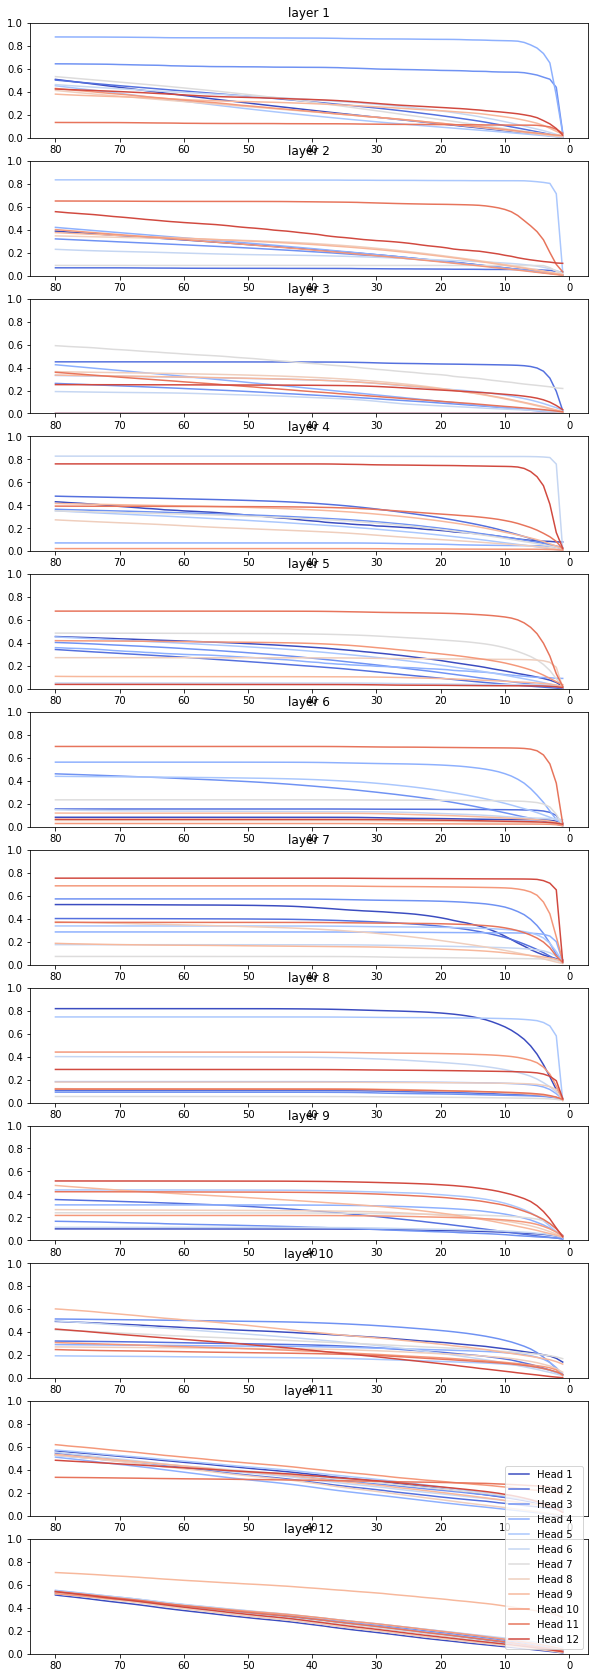

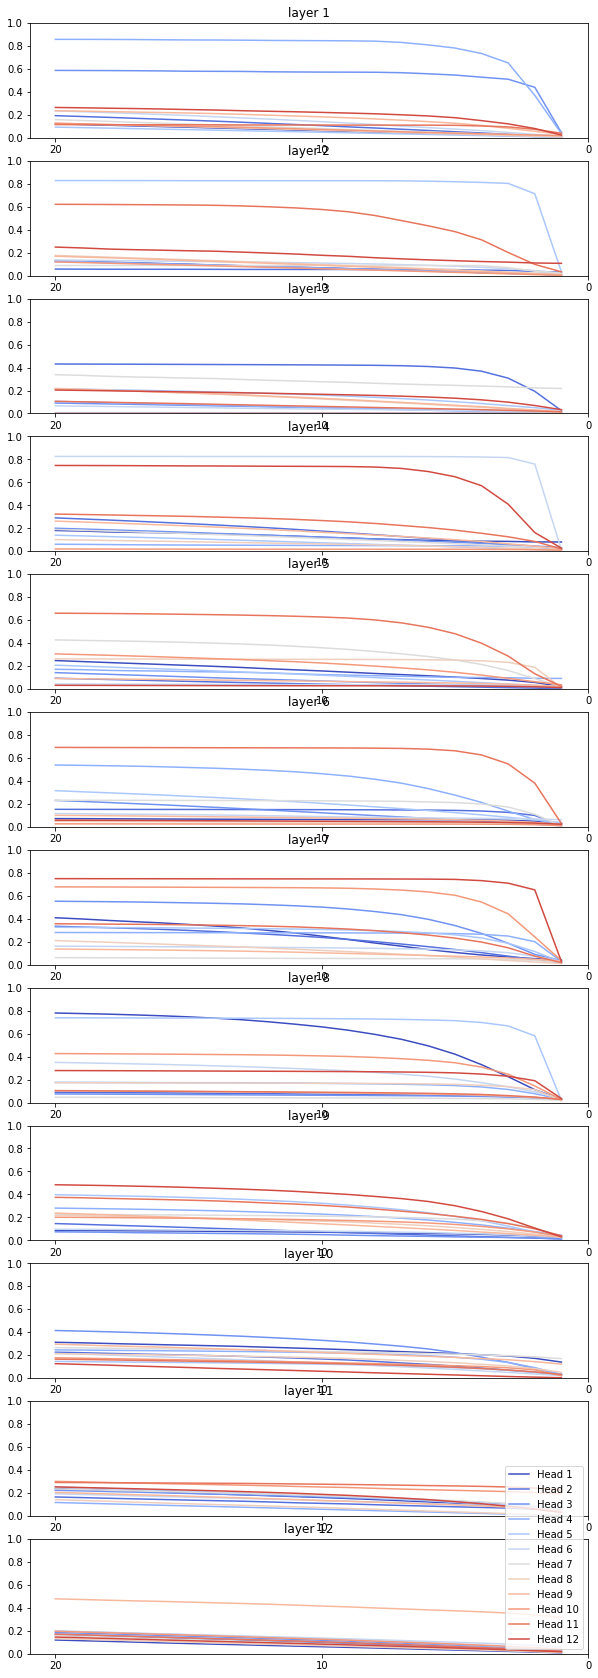

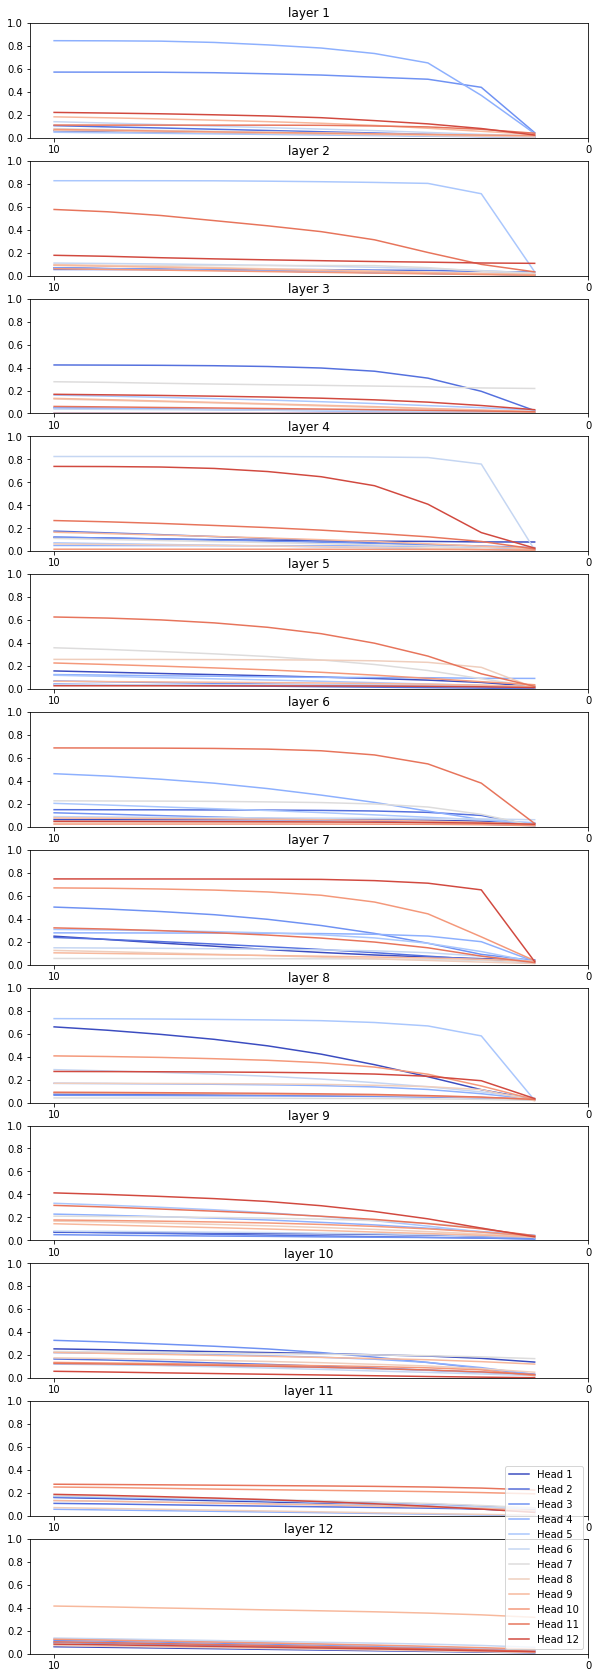

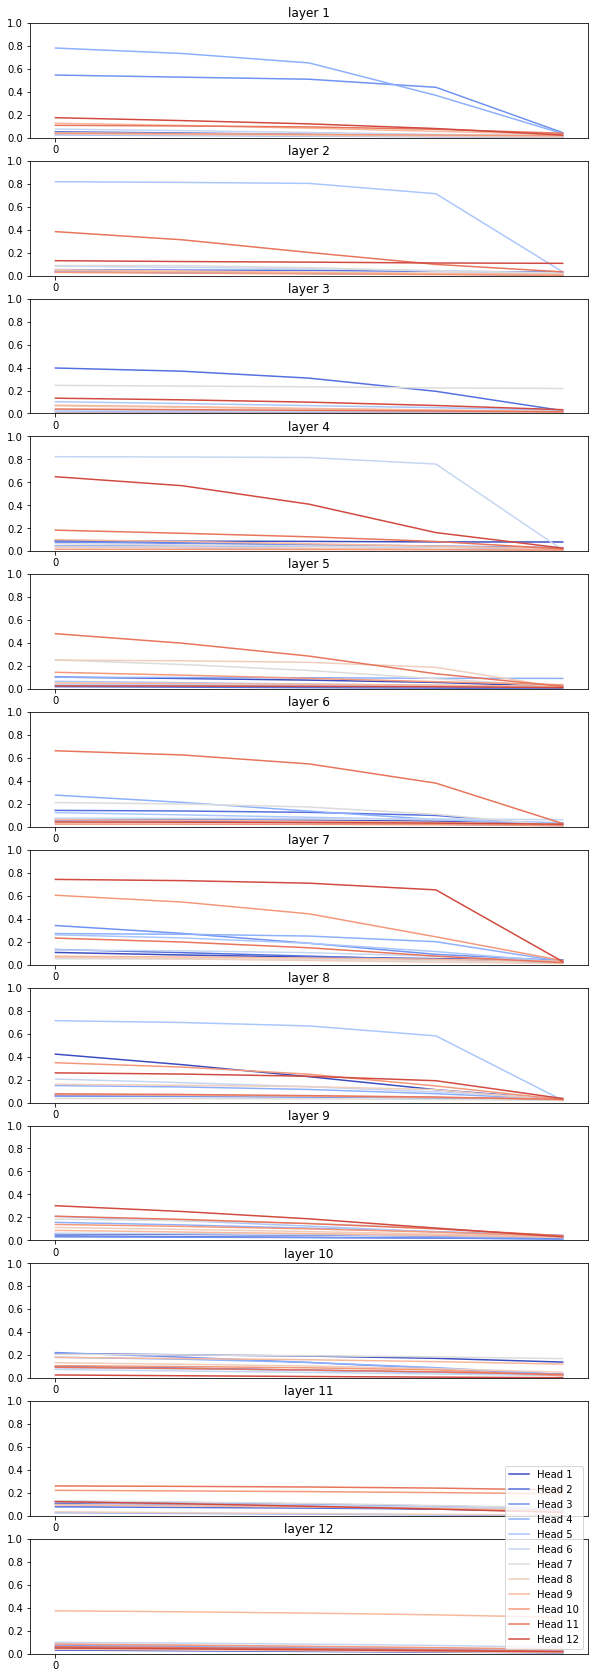

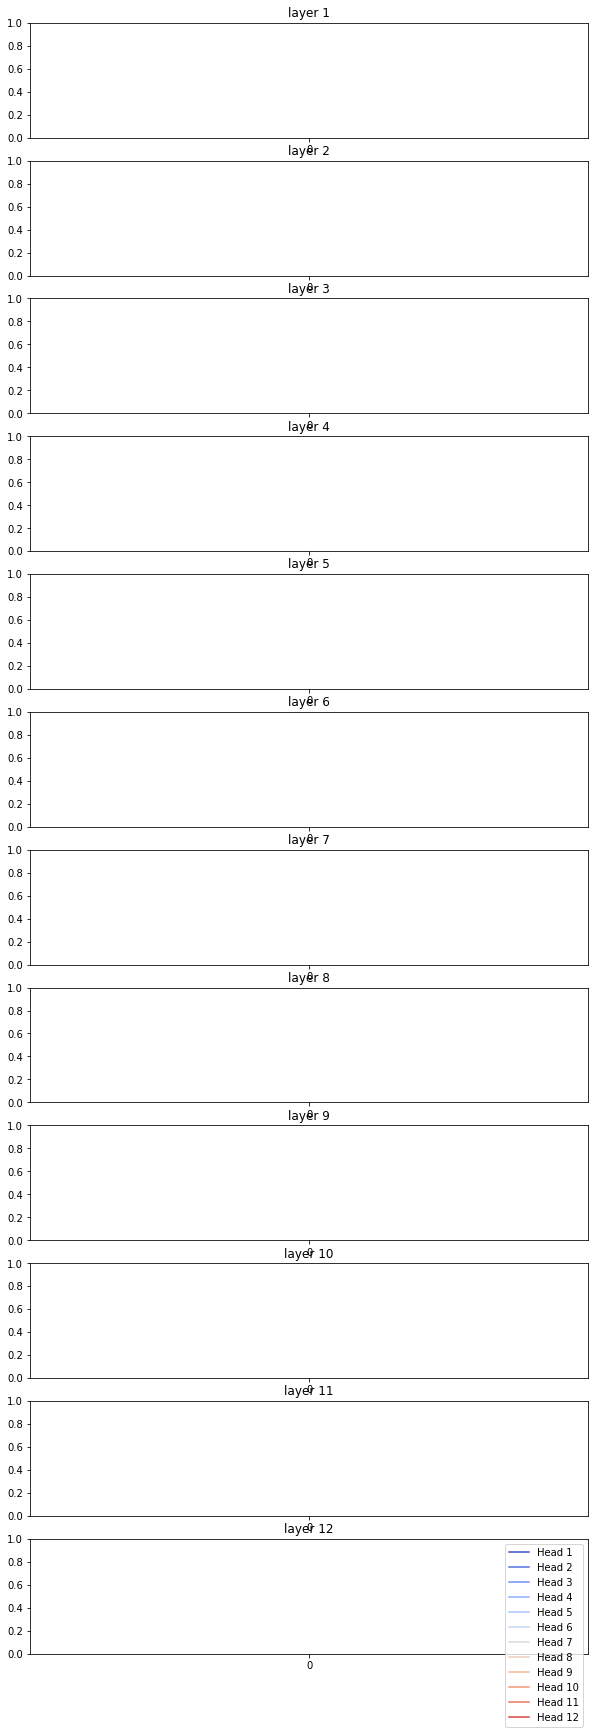

In [20]:


colormap = plt.cm.coolwarm # gist_heat, coolwarm  
colors = [colormap(i) for i in np.linspace(0, 1, 12 + 1)]


for i in list(zip(*attention_weights))[-5:]:
    fig = plt.figure(figsize=(10, 30))
    gs = fig.add_gridspec(12, 1)
    axes = [fig.add_subplot(gs[i, 0]) for i in range(12)]

    tmp = np.mean(np.stack([np.mean(j, axis=-2) for j in i], axis=0), axis=0)
    for j, ax in enumerate(axes):
        for head in range(12):
            #ax.plot(tmp[j, head, :], c=colors[head], label=f"Head {head+1}")
            ax.plot(np.flip(np.cumsum(np.flip(tmp[j, head, :]))), c=colors[head], label=f"Head {head+1}")
        plt.setp(ax, 
                 xticks=np.arange(0, tmp.shape[-1]+1, 10),
                 xticklabels=np.flip(np.arange(0, tmp.shape[-1]+1, 10)),
                )
        ax.set_title(f"layer {j+1}")
    for ax in axes:
        ax.set_ylim((0, 1))
    plt.legend()
    plt.show()
#

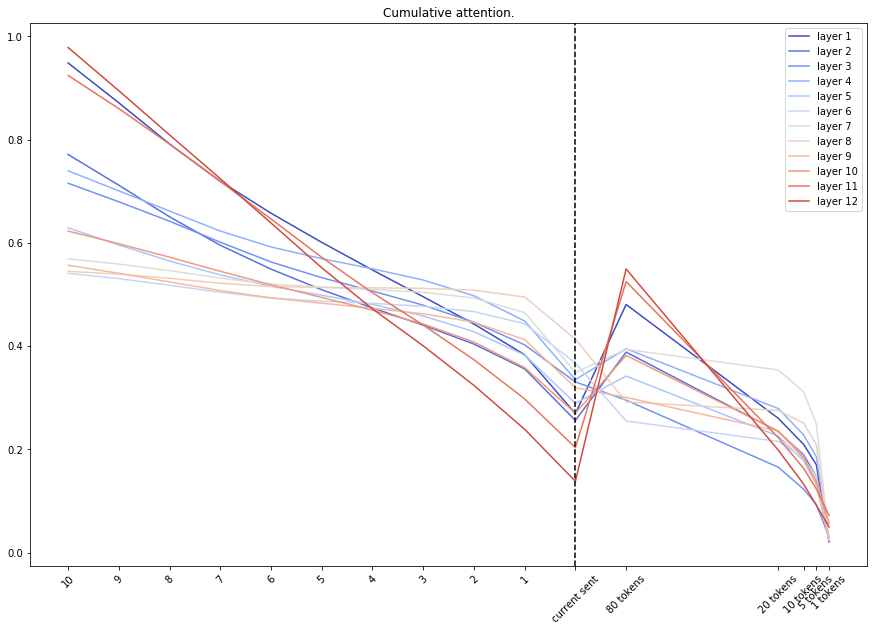

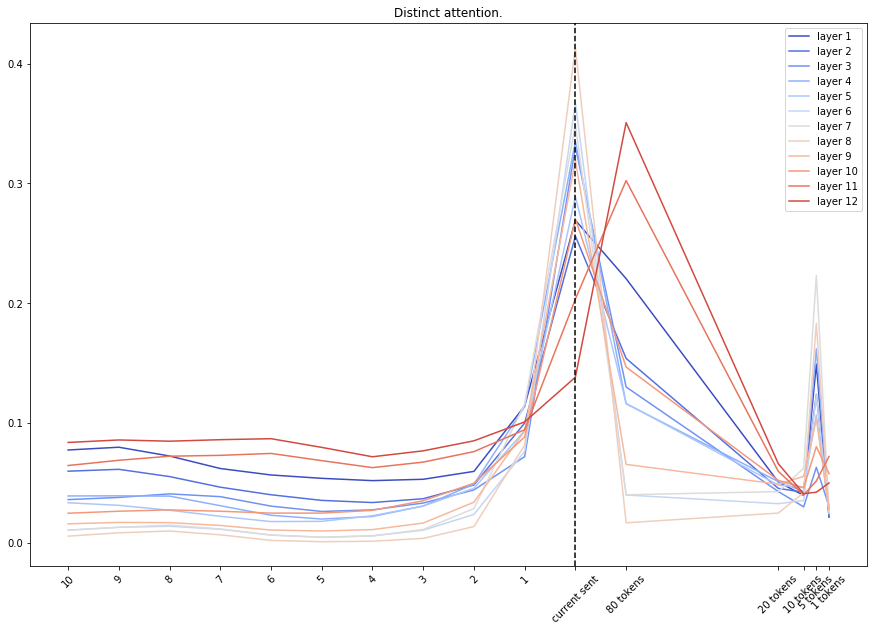

In [16]:
# Per layer
res = []
for i in zip(*attention_weights): #attention_weights[10:]
    attention = np.mean(np.stack([np.mean(np.mean(np.sum(j, axis=-1), axis=-1), axis=1) for j in i], axis=0), axis=0)
    #print(attention.shape)
    res.append(attention)
res = np.stack(res).T
res_cum = np.concatenate([np.flip(np.cumsum(np.flip(res[:, :11], axis=-1), axis=-1), axis=-1), res[:, 11:]], axis=-1)
#print(res.shape)
attention = list(zip(*res))
X = np.hstack([np.arange(12), [14, 14.5, 14.75, 15]])

colormap = plt.cm.coolwarm # gist_heat, coolwarm  
colors = [colormap(i) for i in np.linspace(0, 1, res.shape[0] + 1)]

# Cumulative
fig = plt.figure(figsize=(15, 10))
for i, j in enumerate(res_cum):
    plt.plot(X, j, label=f'layer {i+1}', c=colors[i])
plt.legend()
plt.axvline(x=10, c='black', linestyle='--')
plt.title("Cumulative attention.")
plt.xticks(X, [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, "current sent", '80 tokens', '20 tokens', '10 tokens', '5 tokens', '1 tokens'], rotation=45)
plt.show()

# Distinct attention
fig = plt.figure(figsize=(15, 10))
res = np.concatenate([res[:, :11], np.stack([res[:, i]-res[:, i+1] for i in range(11, 15)], axis=-1), res[:, -1:]], axis=-1)
for i, j in enumerate(res):
    plt.plot(X, j, label=f'layer {i+1}', c=colors[i])
plt.legend()
plt.axvline(x=10, c='black', linestyle='--')
plt.title("Distinct attention.")
plt.xticks(X, [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, "current sent", '80 tokens', '20 tokens', '10 tokens', '5 tokens', '1 tokens'], rotation=45)
plt.show()

In [57]:
import seaborn as sns

(11, 12, 12)
(12, 11)
###### LAYER 1 ######


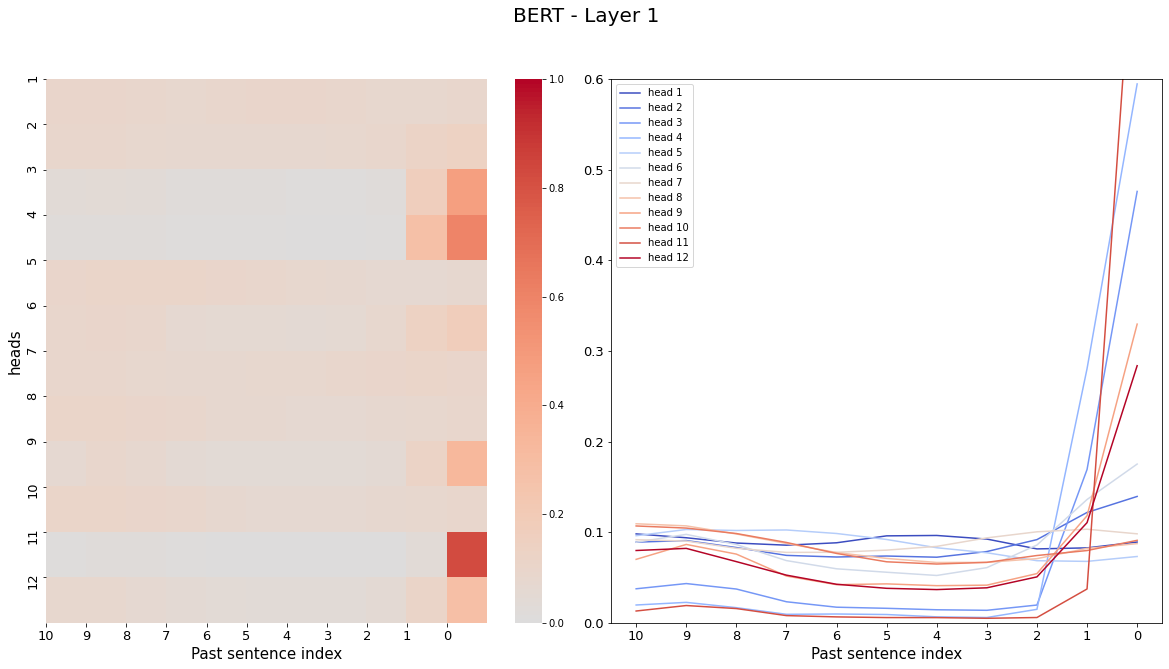



(12, 11)
###### LAYER 2 ######


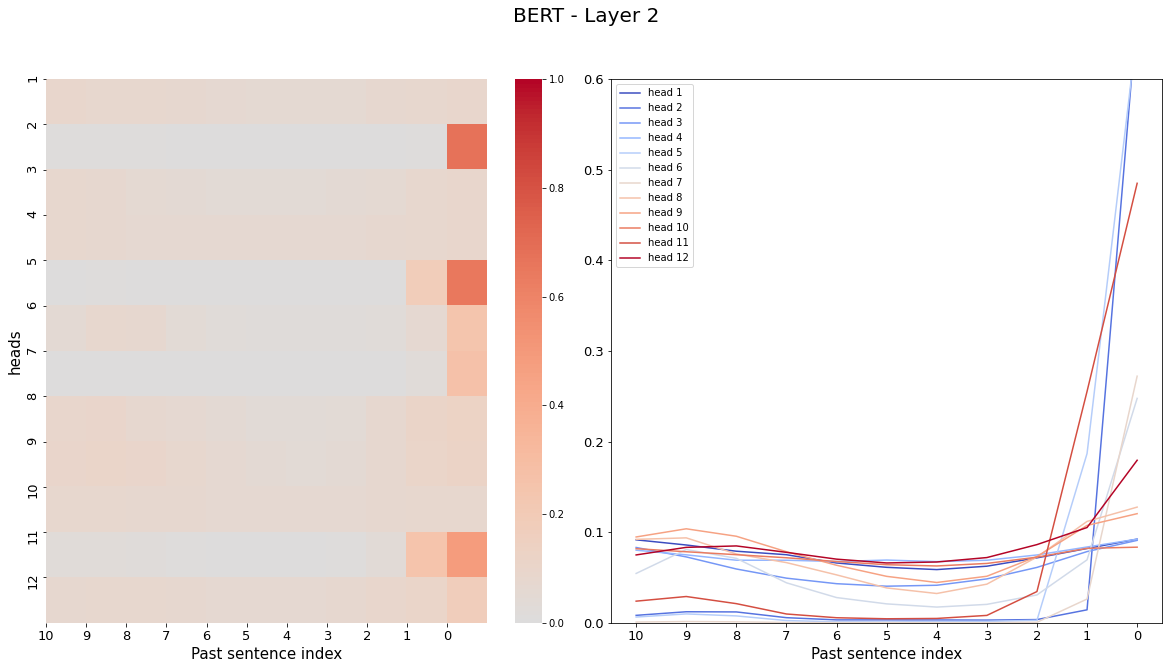



(12, 11)
###### LAYER 3 ######


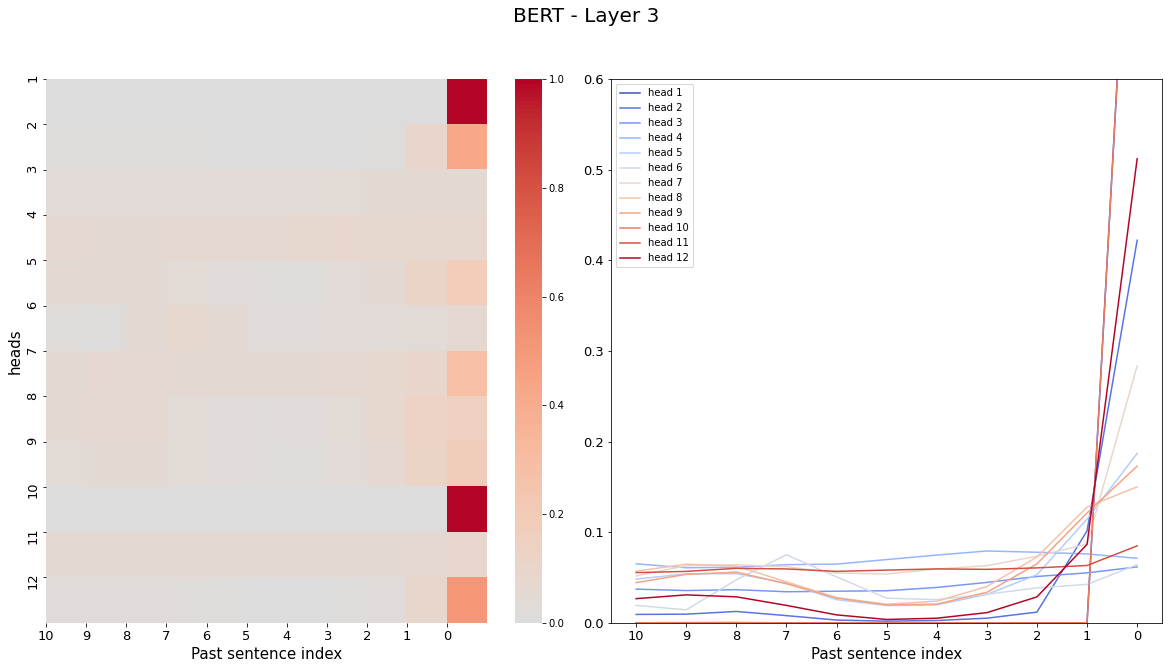



(12, 11)
###### LAYER 4 ######


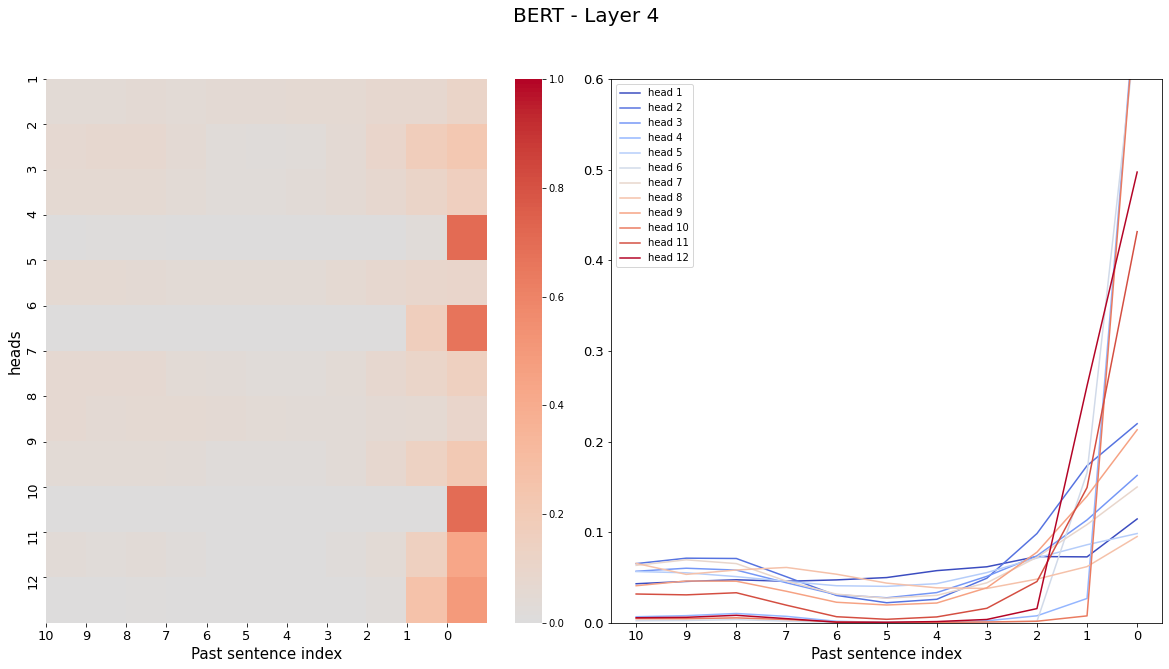



(12, 11)
###### LAYER 5 ######


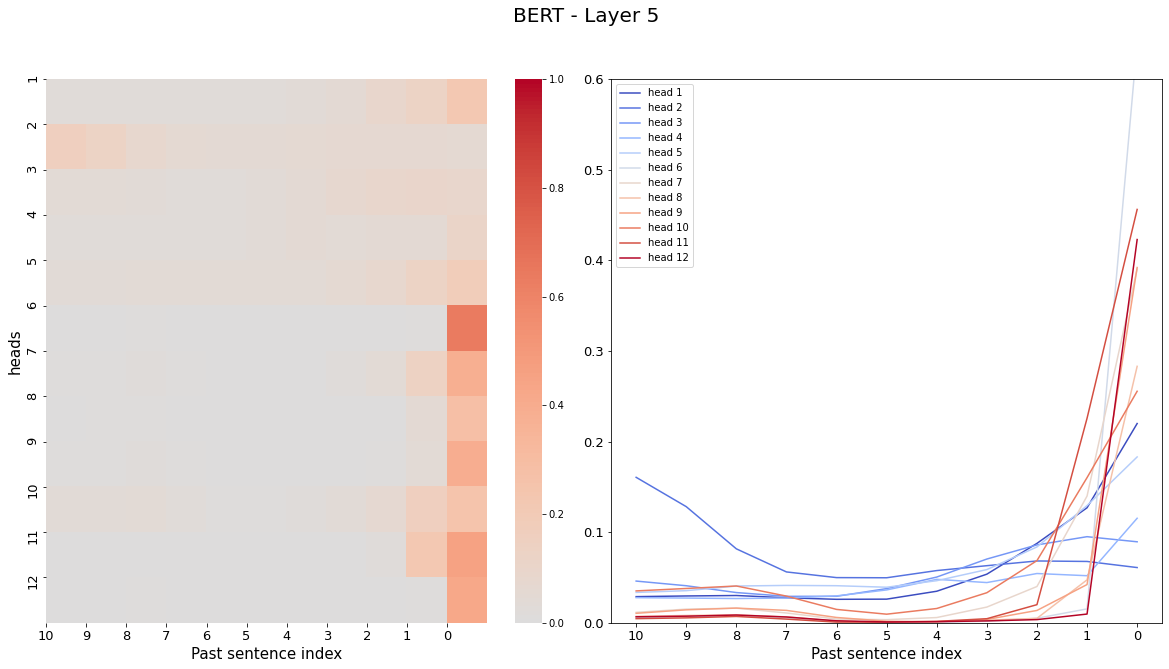



(12, 11)
###### LAYER 6 ######


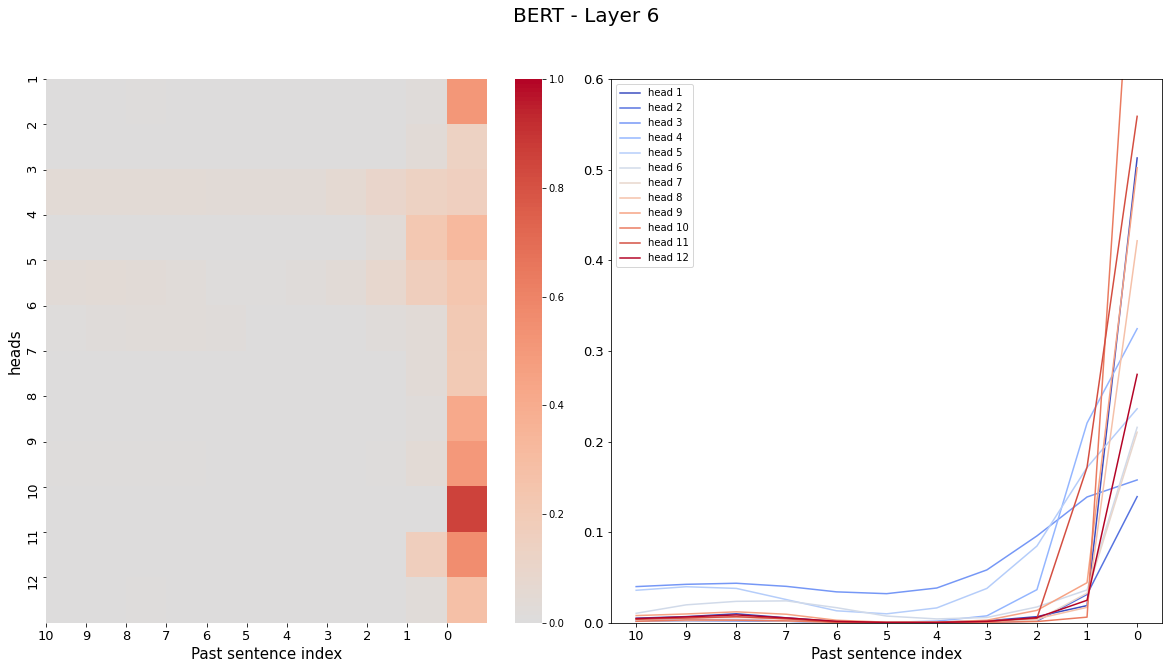



(12, 11)
###### LAYER 7 ######


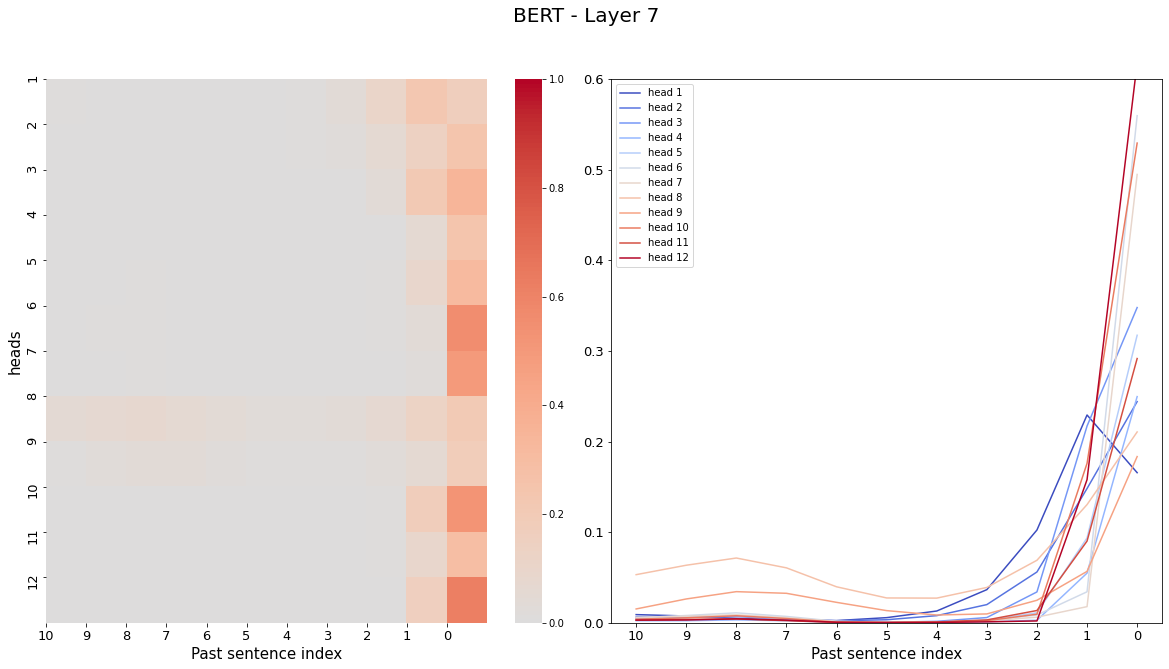



(12, 11)
###### LAYER 8 ######


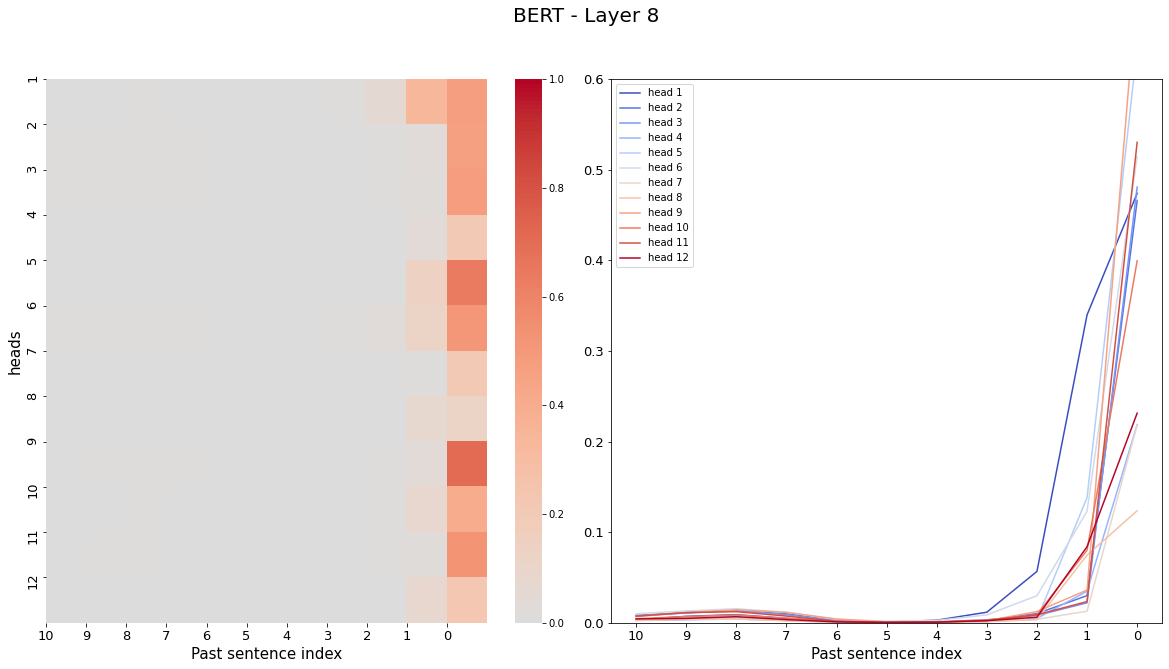



(12, 11)
###### LAYER 9 ######


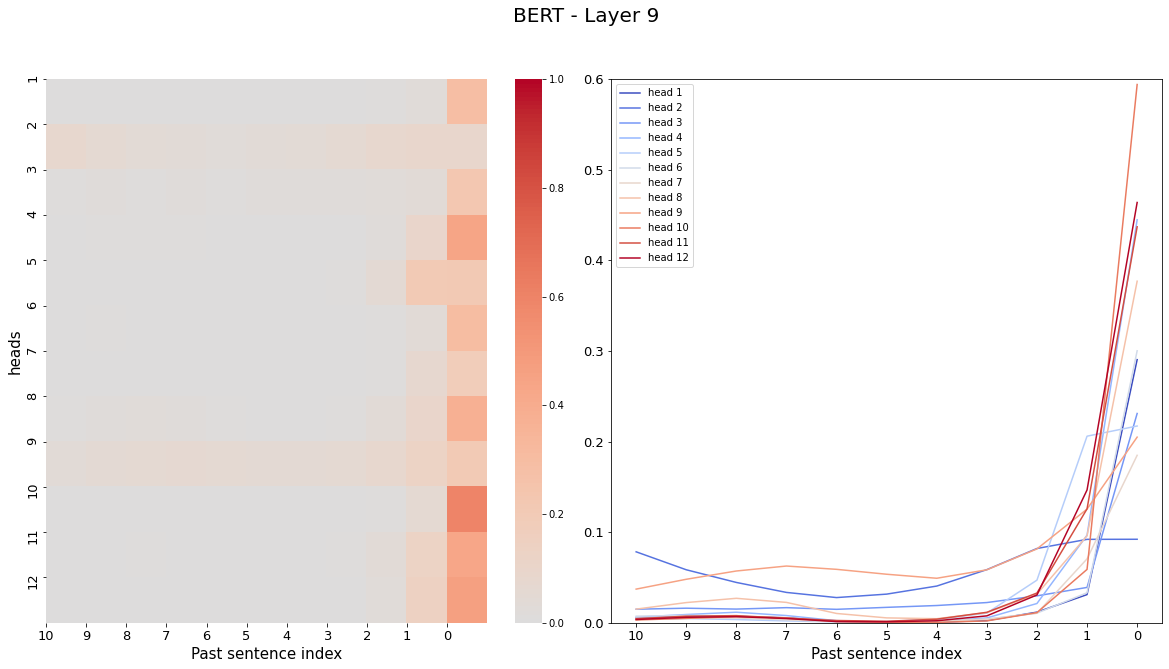



(12, 11)
###### LAYER 10 ######


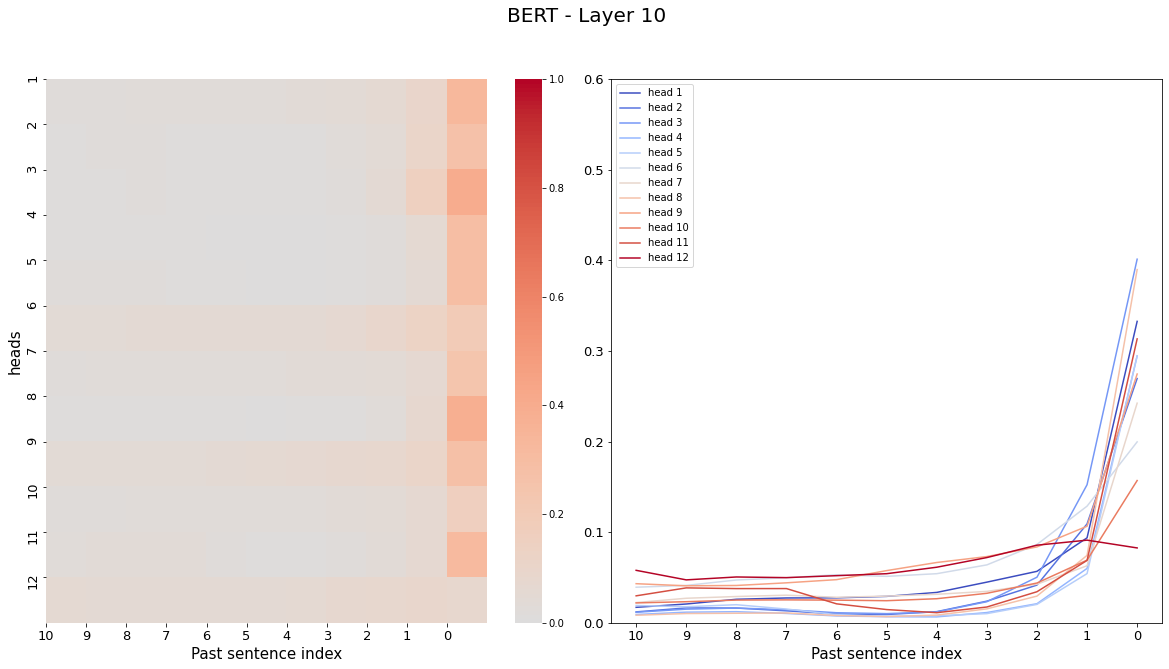



(12, 11)
###### LAYER 11 ######


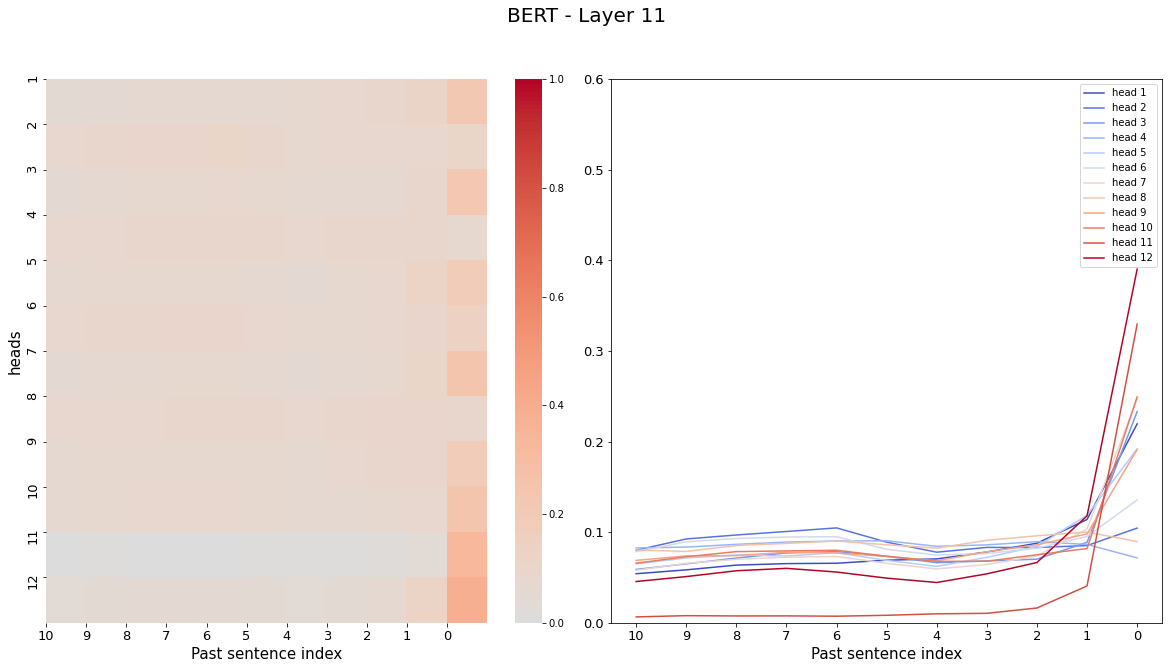



(12, 11)
###### LAYER 12 ######


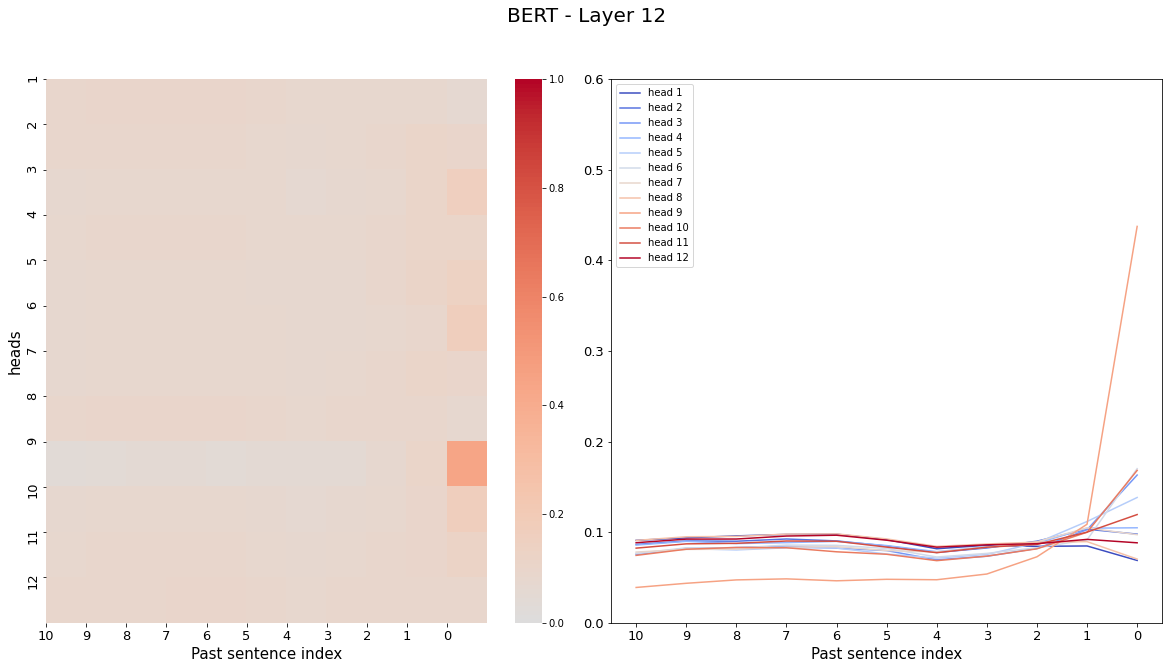

In [86]:
# Per attention-heads
res = []
for i in zip(*attention_weights[10:]):
    attention = np.mean(np.stack([np.mean(np.sum(j, axis=-1), axis=-1) for j in i], axis=0), axis=0)
    #print(attention.shape)
    res.append(attention)
res = np.stack(res, axis=0)
print(res.shape)
for layer in range(res.shape[1]):
    res_tmp = res[:, layer, :].T
    print(res_tmp.shape)
    print(f"###### LAYER {layer+1} ######")
    attention = list(zip(*res_tmp))
    fig = plt.figure(figsize=(20, 10))

    colormap = plt.cm.coolwarm # gist_heat, coolwarm  
    colors = [colormap(i) for i in np.linspace(0, 1, res.shape[0] + 1)]

    gs = fig.add_gridspec(1, 2, width_ratios=[50, 50], wspace=0.025)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    sns.heatmap(res_tmp, ax=ax1, cbar=True, cmap='coolwarm', center=0, vmax=1, vmin=0)
    for i, j in enumerate(res_tmp):
        ax2.plot(j, label=f'head {i+1}', c=colors[i])
    
    ax1.set_ylabel("heads", fontsize=15)
    ax1.set_xlabel("Past sentence index", fontsize=15)
    ax2.set_xlabel("Past sentence index", fontsize=15)
    ax2.set_ylim(0, 0.6)
    plt.legend()
    plt.suptitle(f'BERT - Layer {layer+1}', fontsize=20)
    plt.setp(ax1, 
             xticks=np.arange(11),
             yticks=np.arange(12),
             xticklabels=[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
             yticklabels=np.arange(1, 13),
            )
    ax1.tick_params(axis='x', labelsize=13)
    ax1.tick_params(axis='y', labelsize=13)
    ax2.tick_params(axis='x', labelsize=13)
    ax2.tick_params(axis='y', labelsize=13)
    plt.setp(ax2, 
             xticks=np.arange(11),
             xticklabels=[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
            )
    plt.show()
    print()
    print()

In [65]:
from scipy.spatial import distance

def Euclidean_Dist(df1, df2):
    return np.linalg.norm(df1 - df2)

def compute_distance(d1, d2, method='correlation', filter_data=False):
    #from sklearn.decomposition import PCA
    #d1_ = PCA(300).fit_transform(d1.values)
    #d2_ = PCA(300).fit_transform(d2.values)
    #d1 = pd.DataFrame(data=d1_, columns=['component-{}'.format(i) for i in range(300)])
    #d2 = pd.DataFrame(data=d2_, columns=['component-{}'.format(i) for i in range(300)])
    if filter_data:
        # Keep only hidden states
        d1 = d1[d1.columns[:768*13]]
        d2 = d2[d2.columns[:768*13]]
    if method=='correlation':
        result = d1.corrwith(d2, axis=1, method='pearson')
    elif method=='euclidean':
        result = d1.corrwith(d2, axis=1, method=Euclidean_Dist)
    elif method=='cosine':
        result = d1.corrwith(d2, axis=1, method=distance.cosine)
    return result

In [70]:
# activation generation masked
output = []
for variable in [5, 10, 100, 1000]:
    for index_batch, batch in enumerate(batches_masked):
        batch = batch.strip() # Remove trailing character

        batch = '[CLS] ' + batch + ' [SEP]'
        tokenized_text = tokenizer.wordpiece_tokenizer.tokenize(batch)
        inputs_ids = torch.tensor([tokenizer.convert_tokens_to_ids(tokenized_text)])

        inputs_ids_ref = torch.tensor([tokenizer.convert_tokens_to_ids(tokenized_text)])
        attention_mask_ref = torch.tensor([[1 for x in tokenized_text]])
        print(batch)
        print(inputs_ids.shape)

        inputs_ids = torch.cat(inputs_ids.size(1) * [inputs_ids])
        print(inputs_ids.shape)

        attention_mask =  torch.diag_embed(torch.tensor([[0 for x in tokenized_text]]))

        for i in range(min(len(tokenized_text), config['attention_length_before'])): 
            attention_mask = torch.add(attention_mask, torch.diag_embed(torch.tensor([[1 for x in range(len(tokenized_text) - i)]]), offset=-i))
        for i in range(1, min(len(tokenized_text), variable + 1)): #config['attention_length_after']
            attention_mask = torch.add(attention_mask, torch.diag_embed(torch.tensor([[1 for x in range(len(tokenized_text) - i)]]), offset=i))
        mapping = bert_utils.match_tokenized_to_untokenized(tokenized_text, batch)

        attention_mask = attention_mask.squeeze(0)

        beg = indexes_masked_tmp[index_batch][0] + 1 # because of the special token at the beginning
        end = indexes_masked_tmp[index_batch][1] + 1 # because of special token

        inputs_ids = inputs_ids[beg:end, :]
        attention_mask = attention_mask[beg:end, :]


        print('input shape: ', inputs_ids.shape)
        print('attention_mask shape: ', attention_mask.shape)
        print(batch)
        #print(tokenized_text)
        #print(attention_mask)
        #print('Mapping:')
        #for key in mapping.keys():
        #    print(batch.split()[key], ''.join([tokenized_text[i] for i in mapping[key]]))
        #print('A priori Token of interest:', tokenized_text[beg:end])

        with torch.no_grad():
            encoded_layers = extractor_masked.model(inputs_ids, attention_mask=attention_mask) # last_hidden_state, pooler_output, hidden_states, attentions
            encoded_layers_ref = extractor_masked.model(inputs_ids_ref, attention_mask=attention_mask_ref) # last_hidden_state, pooler_output, hidden_states, attentions

            print('output shape at each layer:', encoded_layers[2][0].shape)
            hidden_states_activations_ = np.vstack([torch.cat([encoded_layers[2][layer][i, beg + i, :].unsqueeze(0) for i in range(encoded_layers[2][layer].size(0))], dim=0).unsqueeze(0).detach().numpy() for layer in range(len(encoded_layers[2]))]) # retrieve all the hidden states (dimension = layer_count * len(tokenized_text) * feature_count)
            print('output shape after concat:', hidden_states_activations_.shape)
            hidden_states_activations_ = np.concatenate([np.zeros((hidden_states_activations_.shape[0], beg , hidden_states_activations_.shape[-1])), hidden_states_activations_, np.zeros((hidden_states_activations_.shape[0], len(tokenized_text) - end, hidden_states_activations_.shape[-1]))], axis=1)

            hidden_states_activations_ref = np.vstack(encoded_layers_ref[2]) # retrieve all the hidden states (dimension = layer_count * len(tokenized_text) * feature_count)

            print(hidden_states_activations_ref.shape)
            print(len(encoded_layers[2]))
            print('output shape after filling:', hidden_states_activations_.shape)

            method = 'correlation'
            print(np.sum(np.isnan(hidden_states_activations_)))
            print(np.sum(np.isnan(hidden_states_activations_ref)))
            print(np.mean([compute_distance(
                pd.DataFrame(hidden_states_activations_[i, beg:end, :]), 
                pd.DataFrame(hidden_states_activations_ref[i, beg:end, :]), 
                method=method) for i in range(13)]))

        #    
        #    new_activations = []
        #    key_start = None
        #    key_stop = None
        #    
        #    assert indexes_masked_tmp[index_batch][0]==indexes_full_tmp[index_batch][0]
        #    assert indexes_masked_tmp[index_batch][1]==indexes_full_tmp[index_batch][1]
        #    
        #    for key_, value in mapping.items(): 
        #        if (value[0] - 1) == (indexes_masked_tmp[index_batch][0]): #because we added [CLS] token at the beginning
        #            key_start = key_
        #    for key_, value in mapping.items(): 
        #        if value[-1] == (indexes_masked_tmp[index_batch][1]): #because we added [CLS] token at the beginning
        #            key_stop = key_
        #            
        #    #print(key_start, key_stop)
        #    #print('Extracting sentence:')
        #    print(' '.join([tokenizer.decode(tokenizer.convert_tokens_to_ids([tokenized_text[word] for word in mapping[index]])) for index in range(key_start, key_stop + 1)]))
        #    #print('dimension match:', len(tokenized_text)==hidden_states_activations_.shape[1])
        #    output.append(' '.join([tokenizer.decode(tokenizer.convert_tokens_to_ids([tokenized_text[word] for word in mapping[index]])) for index in range(key_start, key_stop + 1)]))
        #    
        #    for word_index in range(key_start, key_stop + 1): # len(mapping.keys()) - 1
        #        word_activation = []
        #        word_activation.append([hidden_states_activations_[:,index, :] for index in mapping[word_index]])
        #        word_activation = np.vstack(word_activation)
        #        new_activations.append(np.mean(word_activation, axis=0).reshape(1,-1))
        #    
        #    #print(np.vstack(new_activations).shape)
        if input()!='':
            break
    if input()!='':
        break

assert ' '.join(output) == ' '.join(iterator_list[0])


[CLS] once , when i was six years old , i saw a magnificent picture in a book about the primeval forest called ‘ real - life stories . ’ it showed a boa constrictor swallowing a wild animal . here is a copy of the drawing . it said in the book : “ boa constrictors swallow their prey whole , without chewing . [SEP]
torch.Size([1, 75])
torch.Size([75, 75])
input shape:  torch.Size([30, 75])
attention_mask shape:  torch.Size([30, 75])
[CLS] once , when i was six years old , i saw a magnificent picture in a book about the primeval forest called ‘ real - life stories . ’ it showed a boa constrictor swallowing a wild animal . here is a copy of the drawing . it said in the book : “ boa constrictors swallow their prey whole , without chewing . [SEP]
output shape at each layer: torch.Size([30, 75, 768])
output shape after concat: (13, 30, 768)
(13, 75, 768)
13
output shape after filling: (13, 75, 768)
0
0
0.9321492070672021
a

[CLS] once , when i was six years old , i saw a magnificent picture 

AssertionError: 

In [16]:
# activation generation shuffle
output = []
for index_batch, batch in enumerate(batches_shuffle):
    batch = batch.strip() # Remove trailing character

    batch = '[CLS] ' + batch + ' [SEP]'
    tokenized_text = tokenizer.wordpiece_tokenizer.tokenize(batch)
    inputs_ids = torch.tensor([tokenizer.convert_tokens_to_ids(tokenized_text)])

    #print('input shape: ', inputs_ids.shape)
    #print(batch)
    #print(tokenized_text)
    
    mapping = utils.match_tokenized_to_untokenized(tokenized_text, batch)

    #print('Mapping:')
    #for key in mapping.keys():
    #    print(batch.split()[key], ''.join([tokenized_text[i] for i in mapping[key]]))
    #print('A priori Token of interest:', tokenized_text[indexes_shuffle[index_batch][0]:indexes_shuffle[index_batch][1]])
         
    with torch.no_grad():
        encoded_layers = extractor_shuffle.model(inputs_ids) # last_hidden_state, pooler_output, hidden_states, attentions

        hidden_states_activations_ = np.vstack(encoded_layers[2]) # retrieve all the hidden states (dimension = layer_count * len(tokenized_text) * feature_count)

        #print('nb of layer:', len(encoded_layers[2]))
        #print('output shape:', hidden_states_activations_.shape)
        
        new_activations = []
        key_start = None
        key_stop = None
        
        for key_, value in mapping.items(): 
            if (value[0] - 1) == (indexes_shuffle[index_batch][0]): #because we added [CLS] token at the beginning
                key_start = key_
        for key_, value in mapping.items(): 
            if value[-1] == (indexes_shuffle[index_batch][1]): #because we added [CLS] token at the beginning
                key_stop = key_
                
        #print(key_start, key_stop)
        #print('Extracting sentence:')
        print(' '.join([tokenizer.decode(tokenizer.convert_tokens_to_ids([tokenized_text[word] for word in mapping[index]])) for index in range(key_start, key_stop + 1)]))
        #print('dimension match:', len(tokenized_text)==hidden_states_activations_.shape[1])
        output.append(' '.join([tokenizer.decode(tokenizer.convert_tokens_to_ids([tokenized_text[word] for word in mapping[index]])) for index in range(key_start, key_stop + 1)]))
        
        for word_index in range(key_start, key_stop + 1): # len(mapping.keys()) - 1
            word_activation = []
            word_activation.append([hidden_states_activations_[:,index, :] for index in mapping[word_index]])
            word_activation = np.vstack(word_activation)
            new_activations.append(np.mean(word_activation, axis=0).reshape(1,-1))
        
        #print(np.vstack(new_activations).shape)
        #if input()!='':
        #    break


assert ' '.join(output) == ' '.join(iterator_list[0])


once
,
when
i
was
six
years
old
,
i
saw
a
magnificent
picture
in
a
book
about
the
primeval
forest
called
‘
real
-
life
stories
.
’
it
showed
a
boa
constrictor
swallowing
a
wild
animal
.
here
is
a
copy
of
the
drawing
.
it
said
in
the
book
:
“
boa
constrictors
swallow
their
prey
whole
,
without
chewing
.
then
they
are
not
able
to
move
,
and
they
sleep
for
the
six
months
it
takes
for
digestion
.
”
so
i
thought
a
lot
about
the
adventures
of
the
jungle
and
,
in
turn
,
i
managed
,
with
a
coloured
pencil
,
to
make
my
first
drawing
.
my
drawing
number
one
.
it
looked
like
this
:
i
showed
my
masterpiece
to
the
grownups
and
i
asked
them
if
my
drawing
frightened
them
.
they
answered
me
:
“
why
would
anyone
be
frightened
by
a
hat
?
”
my
drawing
was
not
of
a
hat
.
it
showed
a
boa
constrictor
digesting
an
elephant
.
i
then
drew
the
inside
of
the
boa
constrictor
,
so
that
the
grownups
could
understand
.
they
always
need
to
have
things
explained
.
my
drawing
number
two
looked
like
this
:
the
grownups


gravely
:
“
that
doesn
’
t
matter
;
where
i
live
,
everything
is
so
small
!
”
and
perhaps
with
a
hint
of
sadness
,
he
added
:
“
straight
ahead
you
can
'
t
go
far
...
”


In [24]:
def transform_sentence_and_context(
    iterator, 
    past_context_size, 
    future_context_size, 
    pretrained_model,
    transformation='shuffle',
    vocabulary=None,
    dictionary=None,
    select=None,
    seed=1111):
    """ DEF...
    """
    random.seed(seed)
    punctuation = ['.', '!', '?', '...', '\'', ',', ';', ':', '/', '-', '"', '‘', '’', '(', ')', '{', '}', '[', ']', '`', '“', '”', '—']
    if select is None:
        words = ' '.join(iterator).split()
    else:
        words = iterator[select].split()
        
    all_words = ' '.join(iterator).split()
    words_before = [] if select is None else ' '.join(iterator[:select]).split()
    supp_before = [len([word for word in all_words[max(j+len(words_before)+1-past_context_size, 0):j+len(words_before)+1] if word in punctuation]) for j in range(len(words))] # we do not count punctuation in the number of words to shuffle
    supp_after = [len([word for word in all_words[j+len(words_before)+1:min(j+len(words_before)+1+future_context_size, len(all_words))] if word in punctuation]) for j in range(len(words))] # we do not count punctuation in the number of words to shuffle

    # For each word, we compute the index of the other words to transform
    # We transform past context. Change conditions "i<j" and ... to something else if needed
    index_words_list_before = [[i for i, item in enumerate(all_words) if item not in punctuation if ((i!=(j+len(words_before))) and  (i <= j+len(words_before)-past_context_size-supp_before[j]))] for j in range(len(words))] # '<=' because context_size of 1 is the current word
    index_words_list_after = [[i for i, item in enumerate(all_words) if item not in punctuation if ((i!=(j+len(words_before))) and (i>j+len(words_before)+future_context_size+supp_after[j]))] for j in range(len(words))] # '<=' because context_size of 1 is the current word

    # Create the new array of sentences with original words 
    new_words = np.tile(np.array(all_words.copy()), (len(words), 1))

    for i in range(len(new_words)):
        if len(index_words_list_before[i])>0: # if there are words to change...
            if transformation=='shuffle':
                # Replace words that need to be shuffled by the random sampling (except fix point and punctuation)
                new_order = random.sample(index_words_list_before[i], len(index_words_list_before[i]))
                if len(index_words_list_before[i])>1:
                    while new_order==index_words_list_before[i]:
                        new_order = random.sample(index_words_list_before[i], len(index_words_list_before[i]))
                new_words[i, index_words_list_before[i]] = new_words[i, new_order]
            elif transformation=='pos_replacement':
                # Replace words that need to be replaced by words with same POS (except fix point and punctuation)
                new_words[i, index_words_list_before[i]] = pick_pos_word(new_words[i, index_words_list_before[i]], dictionary)
            elif transformation=='random_replacement':
                # Replace words that need to be replaced by random words (except fix point and punctuation)
                new_words[i, index_words_list_before[i]] = pick_random_word(new_words[i, index_words_list_before[i]], vocabulary)
        if len(index_words_list_after[i])>0: # if there are words to change...
            if transformation=='shuffle':
                new_order = random.sample(index_words_list_after[i], len(index_words_list_after[i]))
                if len(index_words_list_after[i])>1:
                    while new_order==index_words_list_after[i]:
                        new_order = random.sample(index_words_list_after[i], len(index_words_list_after[i]))
                new_words[i, index_words_list_after[i]] = new_words[i, new_order]
            elif transformation=='pos_replacement':
                new_words[i, index_words_list_after[i]] = pick_pos_word(new_words[i, index_words_list_after[i]], dictionary)
            elif transformation=='random_replacement':
                new_words[i, index_words_list_after[i]] = pick_random_word(new_words[i, index_words_list_after[i]], vocabulary)

    # Convert array to list
    new_words = list(new_words)
    new_words = [list(item) for item in new_words]
    batch_tmp = []
    index_tmp = []
    tokenizer = BertTokenizer.from_pretrained(pretrained_model) # to replace with tokenizer of interest
    # adding transformed context to each sentence
    for i, sentence in enumerate(new_words):
        batch_tmp.append(' '.join(sentence).strip())
        # Determining associated indexes
        tmp1 = ' '.join(sentence[:i+len(words_before)])
        tmp2 = ' '.join(sentence[:i+len(words_before)+1])
        index_tmp.append((len(tokenizer.wordpiece_tokenizer.tokenize(tmp1.strip())), 
                     len(tokenizer.wordpiece_tokenizer.tokenize(tmp2.strip()))
                    )) # to replace with tokenizer of interest and arguments
    print(batch_tmp)
    return batch_tmp, index_tmp

In [25]:
iterator= iterator_list[0]
number_of_sentence=config['number_of_sentence']
number_sentence_before=config['number_of_sentence_before']
number_sentence_after=config['number_of_sentence_after']
pretrained_model='bert-base-uncased'
past_context_size=config['attention_length_before']
future_context_size=config['attention_length_after']
transformation='shuffle'
vocabulary=None
dictionary=None
seed=1111
max_length=512


iterator = [item.strip() for item in iterator]
max_length -= 2 # for special tokens
assert number_of_sentence > 0
tokenizer = BertTokenizer.from_pretrained(pretrained_model) # to replace with tokenizer of interest

batch = []
indexes = []
sentence_count = 0
n = len(iterator)


print('entering while loop...')
# rest of the iterator + context 
while sentence_count < n:
    start = max(sentence_count - number_sentence_before, 0)
    stop = min(sentence_count + number_of_sentence, n)
    stop_post_context = min(stop + number_sentence_after, n)
    token_count = len(tokenizer.wordpiece_tokenizer.tokenize(' '.join(iterator[start:stop_post_context]))) # to replace with tokenizer of interest and arguments
    if token_count > max_length:
        raise ValueError('Cannot fit context with additional sentence. You should reduce context length.')
    # computing batch and indexes
    print(len(iterator[start:stop_post_context]))
    print(iterator[start:stop_post_context])
    
    batch_tmp, index_tmp = transform_sentence_and_context(
        iterator[start:stop_post_context], 
        past_context_size=past_context_size,
        future_context_size=future_context_size, 
        pretrained_model=pretrained_model,
        transformation=transformation,
        vocabulary=vocabulary,
        dictionary=dictionary,
        select=stop-start-1,
        seed=seed
    )        
    batch += batch_tmp
    indexes += index_tmp
    sentence_count = stop
    print(stop-start-1)
    if input()!='':
        break

#for b in batch:
#    print(b)
#print(indexes)

entering while loop...
1
['once , when i was six years old , i saw a magnificent picture in a book about the primeval forest called ‘ real - life stories . ’']
['once , i stories in years real about , was forest a the i magnificent old primeval saw book picture called life ‘ six - when a . ’', 'once , the magnificent in life i years , about old forest i saw called was when real picture a stories six ‘ a - book primeval . ’', 'once , when life saw book in i , a picture the called magnificent primeval years six old was about forest a ‘ stories - real i . ’', 'when , once i about magnificent i life , stories real in years old forest a six saw primeval a the was ‘ picture - called book . ’', 'when , i once was years a in , real old i primeval called a forest the saw picture magnificent six stories ‘ book - about life . ’', 'i , when once was six in stories , old i magnificent picture about a real forest primeval called book life saw ‘ a - years the . ’', 'i , six was when once years book ,

In [62]:
import os, yaml
import tqdm
import glob
from joblib import Parallel, delayed
import sys
import random
from collections import Counter
import glob

def save_yaml(data, yaml_path):
    """Open and write safely in a yaml file.
    Arguments:
        - data: list/dict/str/int/float
        -yaml_path: str
    """
    with open(yaml_path, 'w') as outfile:
        yaml.dump(data, outfile, default_flow_style=False)

def merge_two_dicts(dict1, dict2, merge_type='dependence'):
    """Need to iterate over dict1.keys() because 'merge_two_dicts_key' return updated dict2.
    """
    if merge_type=='dependence':
        dict2 = {k: list(set(dict2.get(k) if dict2.get(k) is not None else []).union(set(dict1.get(k) if dict1.get(k) is not None else []))) for k in set(dict2) | set(dict1)}
    #else:
    #    for key in dict1.keys():
    #        dict2 = merge_two_dicts_key(dict1, dict2, key)
    return dict2


def merge_dict(list_of_dict, merge_type='dependence'):
    """Merge a list of dict
    """
    if len(list_of_dict)==0:
        print('input is empty...')
    elif len(list_of_dict)==1:
        return list_of_dict[0]
    else:
        pairs = [[list_of_dict[2*i], list_of_dict[2*i+1]] for i in range(len(list_of_dict)//2)]
        new_list_of_dicts = Parallel(n_jobs=-1)(delayed(merge_two_dicts)(dict1, dict2, merge_type=merge_type) for dict1, dict2 in tqdm(pairs))
        if len(list_of_dict)%2==1:
            new_list_of_dicts.append(list_of_dict[-1])
        return merge_dict(new_list_of_dicts, merge_type=merge_type)
    
def uniform(values):
    """ Pick randomly following uniform distribution
    """
    n = len(values)
    return values[random.randint(0, n-1)]
saving_path = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing'

def tmp(path):
    with open(path, 'r') as stream:
        params = yaml.safe_load(stream)
    return params

files = [
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-950_to-1000.yml',
'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-900_to-950.yml',
'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-850_to-900.yml',
'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-800_to-850.yml',
'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-750_to-800.yml',
'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-700_to-750.yml',
'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-650_to-700.yml',
'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-600_to-650.yml',
'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-550_to-600.yml',
'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-50_to-100.yml',
'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-500_to-550.yml',
'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-450_to-500.yml',
'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-400_to-450.yml',
'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-350_to-400.yml',
'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-300_to-350.yml',
'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-250_to-300.yml',
'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-200_to-250.yml',
'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-150_to-200.yml',
'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-100_to-150.yml',
'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-0_to-50.yml',

]

saving_path = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing'
name = 'dependency_relations_from-0_to-1000.yml'


result_dep_relations = Parallel(n_jobs=-1)(delayed(tmp)(item) for item in files)
result_dep_relations = merge_dict(result_dep_relations, merge_type='dependence')

save_yaml(result_dep_relations, os.path.join(saving_path, name))


TypeError: 'module' object is not callable

In [64]:
merge_dict

<function __main__.merge_dict(list_of_dict, merge_type='dependence')>

In [68]:
result_dep_relations = merge_dict(result_dep_relations, merge_type='dependence')


<class 'function'> 

KeyboardInterrupt: 

## Manipulating syntax

In [13]:
from joblib import Parallel, delayed
import sys
import random
from collections import Counter
import glob
import spacy

def merge_two_dicts_key(dict1, dict2, key):
    """Merge 2 dicts values for a given key into 1.
    We return dict2, because we assume that we iterate in dict1.keys() in the parent function.
    """
    if dict1[key]['text'] in dict2.keys():
        # POS
        dict2[key]['POS'] = {k: dict2[key]['POS'].get(k, 0) +  dict1[key]['POS'].get(k, 0) for k in set(dict2[key]['POS']) | set(dict1[key]['POS'])}
        # TAG
        dict2[key]['tag'] = {k: dict2[key]['tag'].get(k, 0) +  dict1[key]['tag'].get(k, 0) for k in set(dict2[key]['tag']) | set(dict1[key]['tag'])}
        # Dependecy parsing
        dict2[key]['dependency_parsing'] = {k: dict2[key]['dependency_parsing'].get(k, 0) +  dict1[key]['dependency_parsing'].get(k, 0) for k in set(dict2[key]['dependency_parsing']) | set(dict1[key]['dependency_parsing'])}
        # head
        x = dict(Counter(dict2[key]['head']))
        y = dict(Counter(dict1[key]['head']))
        dict2[key]['head'] = {k: x.get(k, 0) + y.get(k, 0) for k in set(x) | set(y)}
        # head_pos
        x = dict(Counter(dict2[key]['head_pos']))
        y = dict(Counter(dict1[key]['head_pos']))
        dict2[key]['head_pos'] = {k: x.get(k, 0) + y.get(k, 0) for k in set(x) | set(y)}
        # morphology
        x = dict(Counter(dict2[key]['morphology']))
        y = dict(Counter(dict1[key]['morphology']))
        dict2[key]['morphology'] = {k: x.get(k, 0) + y.get(k, 0) for k in set(x) | set(y)}
        # entity_IOB
        dict2[key]['entity_IOB'] = {k: dict2[key]['entity_IOB'].get(k, 0) +  dict1[key]['entity_IOB'].get(k, 0) for k in set(dict2[key]['entity_IOB']) | set(dict1[key]['entity_IOB'])}
        # entity_type
        dict2[key]['entity_type'] = {k: dict2[key]['entity_type'].get(k, 0) +  dict1[key]['entity_type'].get(k, 0) for k in set(dict2[key]['entity_type']) | set(dict1[key]['entity_type'])}
        # entity
        dict2[key]['entity'] = {k: dict2[key]['entity'].get(k, 0) +  dict1[key]['entity'].get(k, 0) for k in set(dict2[key]['entity']) | set(dict1[key]['entity'])}

    else:
        dict2[key] = dict1[key].copy()
    return dict2

def merge_two_dicts(dict1, dict2, merge_type='dependence'):
    """Need to iterate over dict1.keys() because 'merge_two_dicts_key' return updated dict2.
    """
    if merge_type=='dependence':
        dict2 = {k: list(set(dict2.get(k) if dict2.get(k) is not None else []).union(set(dict1.get(k) if dict1.get(k) is not None else []))) for k in set(dict2) | set(dict1)}
    else:
        for key in dict1.keys():
            dict2 = merge_two_dicts_key(dict1, dict2, key)
    return dict2


def merge_dict(list_of_dict, merge_type='dependence'):
    """Merge a list of dict
    """
    if len(list_of_dict)==0:
        print('input is empty...')
    elif len(list_of_dict)==1:
        return list_of_dict[0]
    else:
        pairs = [[list_of_dict[2*i], list_of_dict[2*i+1]] for i in range(len(list_of_dict)//2)]
        print(type(merge_two_dicts), pairs)
        new_list_of_dicts = Parallel(n_jobs=-1)(delayed(merge_two_dicts)(dict1, dict2, merge_type=merge_type) for dict1, dict2 in tqdm(pairs))
        if len(list_of_dict)%2==1:
            new_list_of_dicts.append(list_of_dict[-1])
        return merge_dict(new_list_of_dicts, merge_type=merge_type)
    
def uniform(values):
    """ Pick randomly following uniform distribution
    """
    n = len(values)
    return values[random.randint(0, n-1)]

def generate_pos_freq_sample(nlp, sentence, dep_relations_dict, n_samples=50, limit_iterations=3000, information_type='tag', use_morph=True, same_freq=True, word_freq=None, skip_punctuation=True):
    """Generate sentence with same POS, dependecy parsing and syntaxic tree.
    freq_dict is the log frequency dictionary whose keys are vocabulary words.
    """
    punctuation = ['\'', ',', ';', ':', '/', '-', '"', '‘', '’', '(', ')', '{', '}', '[', ']', '`', '“', '”', '—', '.', '!', '?', '...']
    doc = nlp(sentence)
    root = [token for token in doc if token.head == token][0]
    ref_tree_representation = doc_to_tree(doc, root)
    # Iterating to generate samples
    i=0
    count=0
    new_samples = []
    while (i < n_samples) and (count < limit_iterations):
        sample = []
        for token in doc:
            if (token.text.lower() in punctuation) and skip_punctuation:
                sample.append(token.text.lower())
            else:
                # Computing dependency relationships with head and children
                keys = []
                if information_type=='tag':
                    all_children = [token.tag_]
                elif information_type=='pos':
                    all_children = [token.pos_]
                elif information_type=='dep':
                    all_children = [token.dep_]
                for child in token.children:
                    if information_type=='tag':
                        keys.append(str([token.tag_, child.tag_]))
                        all_children.append(child.tag_)
                    elif information_type=='pos':
                        keys.append(str([token.pos_, child.pos_]))
                        all_children.append(child.pos_)
                    elif information_type=='dep':
                        keys.append(str([token.dep_, child.dep_]))
                        all_children.append(child.dep_)
                keys.append(str(all_children))
                if use_morph:
                    for index in range(len(keys)):
                        keys[index] += str(token.morph)
                # Retrieving possible words to replace 'token'
                for index, key in enumerate(keys):
                    keys[index] = str(uuid.uuid3(uuid.NAMESPACE_DNS, str(key)).hex)
                index = len(keys)-1
                while (keys[index] not in dep_relations_dict.keys()) and (index>=0):
                    index -= 1
                if index<0:
                    raise KeyError
                possible_words = dep_relations_dict[keys[index]]
                if same_freq:
                    possible_words = filter_list(possible_words, word_freq, word_freq[token.text.lower()])
                print(token.text, possible_words)
                sample.append(uniform(possible_words))
        new_sentence = ' '.join(sample)
        doc_sample = nlp(' '.join(sample))
        root = [token for token in doc_sample if token.head == token][0]
        tree_representation = doc_to_tree(doc_sample, root)
        if tree_representation==ref_tree_representation:
            i+=1
            new_samples.append(new_sentence)
        count+=1
    print('done in ', count, ' iterations.')
    return new_samples


def batchify(train_data):
    """
    """
    train = train_data.replace('<eos>', '').replace('<unk>', '').split('\n')
    batches = [' '.join(train[i*5000:(i+1)*5000]) for i in range(len(train)//5000)]
    return batches

def doc_to_tree(doc, root, tree_type='pos'):
    """Create linear tree structure to represent dependency parsing.
    """
    representation = [root.pos_ if tree_type=='pos' else root.tag_]
    tmp = []
    for descendant in root.children:
        tmp.append(doc_to_tree(doc, descendant))
    representation += tmp
    return representation


def get_sentence_tree_dict(tree_data, tree_type='pos'):
    """Train data should have been prepared with :
    ''' tree_data = train_data.replace('<eos>', '').replace('<unk>', '').split('\n') '''
    tree_data should be a list of sentences.
    """
    tree_dict = {}
    for sentence in tqdm(tree_data):
        doc = nlp(sentence)
        root = [token for token in doc if token.head == token][0]
        tree_representation = doc_to_tree(doc, root, tree_type=tree_type)
        order = [token.dep_ for token in doc]
        if str(tree_representation) in tree_dict.keys():
            if str(order) in tree_dict[str(tree_representation)].keys():
                for index_token, token in enumerate(doc):
                    if token.text.lower() not in tree_dict[str(tree_representation)][str(order)][index_token]:
                        tree_dict[str(tree_representation)][str(order)][index_token].append(token.text.lower())
            else:
                tree_dict[str(tree_representation)][str(order)] = [[token.text.lower()] for token in doc]
        else:
            tree_dict[str(tree_representation)] = {}
            tree_dict[str(tree_representation)][str(order)] = [[token.text.lower()] for token in doc]
    return tree_dict


def update_dependency_dict(token, dep_relations={}, key_type='dep', use_children=True):
    """Update a dictionary where keys are dependency relationships.
    And values are list of possible words.
    """
    word = token.text.lower()
    # determining type of key
    # DEP
    if key_type=='dep':
        if use_children:
            keys = []
            all_children = [token.dep_]
            for child in token.children:
                keys.append(str([token.dep_, child.dep_]))
                all_children.append(child.dep_)
            keys.append(str(all_children))
        else:
            keys = [str(token.dep_)]
    # POS
    elif key_type=='pos':
        if use_children:
            keys = []
            all_children = [token.head.pos_, token.pos_]
            for child in token.children:
                keys.append(str([token.head.pos_, token.pos_, child.pos_]))
                all_children.append(child.pos_)
            keys.append(str(all_children))
        else:
            keys = [str([token.head.pos_, token.pos_])]
    # TAG
    elif key_type=='tag':
        if use_children:
            keys = []
            all_children = [token.head.tag_, token.tag_]
            for child in token.children:
                keys.append(str([token.head.tag_, token.tag_, child.tag_]))
                all_children.append(child.tag_)
            keys.append(str(all_children))
        else:
            keys = [str([token.head.tag_, token.tag_])]
    final_keys = []
    for key in keys:
        final_keys.append(key + str(token.morph))
    for index, key in enumerate(final_keys):
        final_keys[index] = uuid.uuid3(uuid.NAMESPACE_DNS, str(key)).hex
    # updating the dictionary
    for key in final_keys:
        if key in dep_relations.keys():
            if word not in dep_relations[key]:
                dep_relations[key].append(word)
        else:
            dep_relations[key] = [word]
        
def update_parsing_dict(token, data_dict={}):
    """Update a dictionary with all general relationships in language.
    """
    word = token.text.lower()
    if word not in data_dict.keys():
        data_dict[word] = {
            'text': word,
            'lemma': token.lemma_,
            'POS': {token.pos_: 1},
            'tag': {token.tag_: 1},
            'dependency_parsing': {token.dep_: 1},
            'head': [token.head.text.lower()],
            'head_pos': [token.head.pos_],
            'shape': token.shape_,
            #'is_alpha': [token.is_alpha],
            #'is_stop': [token.is_stop],
            'morphology': [str(token.morph)],
            'entity_IOB': {token.ent_iob_: 1},
            'entity_type': {token.ent_type_: 1},
            'entity': {token.ent_kb_id_: 1},
        }
    else:
        # POS
        if token.pos_ in data_dict[word]['POS'].keys():
            data_dict[word]['POS'][token.pos_] +=1
        else:
            data_dict[word]['POS'][token.pos_] =1
        # TAG
        if token.tag_ in data_dict[word]['tag'].keys():
            data_dict[word]['tag'][token.tag_] +=1
        else:
            data_dict[word]['tag'][token.tag_] =1
        # Dependecy parsing
        if token.dep_ in data_dict[word]['dependency_parsing'].keys():
            data_dict[word]['dependency_parsing'][token.dep_] += 1
        else:
            data_dict[word]['dependency_parsing'][token.dep_] = 1
        # head
        data_dict[word]['head'].append(token.head.text.lower())
        # head_pos
        data_dict[word]['head_pos'].append(token.head.pos_)
        # is_alpha
        #data_dict[word]['is_alpha'].append(token.is_alpha)
        # is_stop
        #data_dict[word]['is_stop'].append(token.is_stop)
        # morphology
        data_dict[word]['morphology'].append(str(token.morph))
        # entity_IOB
        if token.ent_iob_ in data_dict[word]['entity_IOB'].keys():
            data_dict[word]['entity_IOB'][token.ent_iob_] += 1
        else:
            data_dict[word]['entity_IOB'][token.ent_iob_] = 1
        # entity_type
        if token.ent_type_ in data_dict[word]['entity_type'].keys():
            data_dict[word]['entity_type'][token.ent_type_] += 1
        else:
            data_dict[word]['entity_type'][token.ent_type_] = 1
        # entity
        if token.ent_type_ in data_dict[word]['entity'].keys():
            data_dict[word]['entity'][token.ent_kb_id_] += 1
        else:
            data_dict[word]['entity'][token.ent_kb_id_] = 1
            
def get_dep_and_parsing_dicts(train, index, saving_path):
    """
    """
    doc = nlp(train)
    #data_dict = {}
    dep_relations = {}
    for index, token in tqdm(enumerate(doc)):
        try:
            update_dependency_dict(token, dep_relations=dep_relations, key_type='dep')
            update_dependency_dict(token, dep_relations=dep_relations, key_type='pos')
            update_dependency_dict(token, dep_relations=dep_relations, key_type='tag')
            #update_parsing_dict(token, data_dict=data_dict)
        except Exception as e:
            print(e)
    return dep_relations
    #save_yaml(dep_relations, os.path.join(saving_path, 'dep_relations-{}.yml'.format(index)))
    #tree_data = train_data.replace('<eos>', '').replace('<unk>', '').split('\n')
    #tree_dict = get_sentence_tree_dict(tree_data)
    #return data_dict, dep_relations


def read_yaml(yaml_path):
    """Open and read safely a yaml file."""
    with open(yaml_path, 'r') as stream:
        try:
            parameters = yaml.safe_load(stream)
        except :
            print("Couldn't load yaml file: {}.".format(yaml_path))
            quit()
    return parameters

def save_yaml(data, yaml_path):
    """Open and write safely in a yaml file.
    Arguments:
        - data: list/dict/str/int/float
        -yaml_path: str
    """
    with open(yaml_path, 'w') as outfile:
        yaml.dump(data, outfile, default_flow_style=False)
    
def write(path, text, end='\n'):
    """Write in the specified text file."""
    with open(path, 'a+') as f:
        f.write(text)
        f.write(end)

def check_folder(path):
    """Create adequate folders if necessary."""
    try:
        if not os.path.isdir(path):
            check_folder(os.path.dirname(path))
            os.mkdir(path)
    except:
        pass

In [14]:
def uniform(values):
    """ Pick randomly following uniform distribution
    """
    n = len(values)
    return values[random.randint(0, n-1)]

# Filter a list based on criteria
def filter_list(list_to_filter, values, reference):
    """ Filter a list based on criteria
    """
    def keep(word):
        if np.abs(values[word] - reference) <= 1:
            return word
    new_list = map(keep, list_to_filter)
    # we remove None values
    new_list = list(filter(None, new_list))
    return new_list

def generate_freq_sample(sentence, n_samples, word_list, word_freq, skip_punctuation=True, limit_iterations=1000):
    """Generate sentence with same frequency.
    freq_dict is the log frequency dictionary whose keys are vocabulary words.
    """
    punctuation = ['\'', ',', ';', ':', '/', '-', '"', '‘', '’', '(', ')', '{', '}', '[', ']', '`', '“', '”', '—', '.', '!', '?', '...']
    def sample_sentence():
        sample = []
        for word in sentence.split():
            if skip_punctuation and (word in punctuation):
                sample.append(word)
            else:
                possible_words = filter_list(word_list, word_freq, word_freq[word])
                sample.append(uniform(possible_words))
        new_sentence = ' '.join(sample)
        return new_sentence
    new_samples = Parallel(n_jobs=-1)(delayed(sample_sentence)() for _ in range(n_samples))

    return new_samples

In [15]:
dep_relations_dict_1 = read_yaml('/Volumes/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/dependency_relations_from-0_to-1000.yml')


In [21]:
#from get_dependency_parsing import generate_pos_freq_sample, generate_freq_sample, filter_list

english_words_data = pd.read_csv('/Volumes/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/text/english/lexique_database.tsv', delimiter='\t')
# Creating dict with freq information
word_list = english_words_data['Word'].apply(lambda x: str(x).lower()).values
freq_list = english_words_data['Lg10WF'].values
zip_freq = zip(word_list, freq_list)
word_freq = dict(zip_freq)


for sentence in iterator_list[0][:2]:
    print(sentence)
    print(generate_freq_sample(sentence, 10, word_list, word_freq, skip_punctuation=True))
    print()
    print(generate_pos_freq_sample(nlp, sentence, dep_relations_dict_1, n_samples=1, limit_iterations=3000, information_type='tag', use_morph=True, same_freq=True, word_freq=word_freq, skip_punctuation=True))
    print()
    print()

once , when i was six years old , i saw a magnificent picture in a book about the primeval forest called ‘ real - life stories . ’
['promised , boys it must row hand they , in dollars going complex true t want forgot was get matzoth sponge since ‘ beach - gonna yo . ’', 'science , em me guys relationship america fly , for leaves was rich twins all get sally pretty got infuriate busted ones ‘ got - probably prep . ’', 'forgive , young they i explain jimmy husband , t type right indians recommend way what special uh up commitments outstanding wasn ‘ upset - name jersey . ’', 'starting , anyway no they ma hands major , don movies ll sahara former is i video sure was baedeker stuffed force ‘ cost - coming sometime . ’', 'honor , left like lot orange joke being , are animal going clicks uniform very about space fuck re procuring embarrass david ‘ showed - ma nicky . ’', 'bank , will right home plain pick ln , don idea on hag woman what not rich hello your cufflink licking said ‘ bus - might

KeyError: 

In [11]:
# Intersection of two lists
def intersect(list1, list2):
    """ Intersects two lists
    """
    tmp = set(list2)
    list3 = [value for value in list1 if value in tmp]
    return list3

list1 = pd.read_csv('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/text/english/lexique_database.tsv', delimiter='\t')

list1 = list1[['Word', 'Lg10WF']]  


Spacy Parser:

In [24]:
nlp = spacy.load("en_core_web_lg")
nlp.remove_pipe("ner")
nlp.max_length = np.inf
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']


Testing on LPP:

In [44]:


doc = nlp(' '.join(iterator_list[0]))
data = []
for index, token in enumerate(doc):
    data.append([token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.head.text, token.head.pos_,
            token.shape_, token.is_alpha, token.is_stop, token.morph, token.ent_iob_, token.ent_type_, token.ent_kb_id_])
    #print(ref[index], token.text)
df = pd.DataFrame(data, columns=['text', 'lemma', 'POS', 'tag', 'dependency parsing', 'head', 'head_pos', 'shape', 
                                 'is_alpha', 'is_stop', 'morphology', 'entity_IOB', 'entity_type', 'entity'
                                ])
df

,text,lemma,POS,tag,dependency parsing,head,head_pos,shape,is_alpha,is_stop,morphology,entity_IOB,entity_type,entity
0,once,once,ADV,RB,advmod,saw,VERB,xxxx,True,True,(),O,,
1,",",",",PUNCT,",",punct,saw,VERB,",",False,False,(PunctType=Comm),O,,
2,when,when,ADV,WRB,advmod,was,VERB,xxxx,True,True,(),O,,
3,i,I,PRON,PRP,nsubj,was,VERB,x,True,True,"(Case=Nom, Number=Sing, Person=1, PronType=Prs)",O,,
4,was,be,VERB,VBD,advcl,saw,VERB,xxx,True,True,"(Mood=Ind, Number=Sing, Person=3, Tense=Past, ...",O,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,t,t,NOUN,NN,nsubj,go,VERB,x,True,False,(Number=Sing),O,,
1891,go,go,VERB,VB,ccomp,added,VERB,xx,True,True,(VerbForm=Inf),O,,
1892,far,far,ADV,RB,advmod,go,VERB,xxx,True,False,(),O,,
1893,...,...,PUNCT,NFP,punct,added,VERB,...,False,False,(),O,,


In [25]:
# train on Wikipedia
train_data = open('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/text/english/lstm_training/train.txt', 'r').read()
train = train_data.replace('<eos>', '').replace('\n', '').replace('<unk>', '')

train_batch = batchify(train_data)


In [37]:
# Train on Project Gutenberg
train_batch = sorted(glob.glob('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/text/english/Gutenberg/txt/*'))


In [13]:
def f(train, index, saving_path, preprocess=False):
    """
    """
    if preprocess:
        train = open(train, 'r').read()
        train = train.replace('\n', ' ').replace("\'", ' ').replace('_', ' ')
        train = ' '.join(train.split())
    get_dep_and_parsing_dicts(train, index, saving_path)

In [ ]:
saving_path = '/home/ap263679/tmp/dependency_parsing'
merge_every = 200
result_dep_relations = []
result_data_dict = []

for index, train in tqdm(enumerate(train_batch)):
    f(train, index=index, saving_path=saving_path, preprocess=True)


for i in range(0, len(train_batch)//merge_every):
    gc.collect()
    results = Parallel(n_jobs=-2)(delayed(f)(train, index=index, saving_path=saving_path, preprocess=True) for train in tqdm(train_batch[i*merge_every:(i+1)*merge_every]))
    res = list(zip(*results))
    #result_data_dict += res[0]
    result_dep_relations += res[1]
    result_dep_relations = merge_dict(result_dep_relations, merge_type='dependence')
    #result_data_dict = merge_dict(result_data_dict)


0it [00:00, ?it/s]

In [19]:
saving_path = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing'

def tmp(path):
    with open(path, 'r') as stream:
        params = yaml.safe_load(stream)
    return params

result_dep_relations = Parallel(n_jobs=-1)(delayed(tmp)(item) for item in tqdm(sorted(glob.glob(f'/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-*_to-*.yml'))))
result_dep_relations = merge_dict(result_dep_relations, merge_type='dependence')

save_yaml(result_dep_relations, os.path.join(saving_path, 'dependency_relations.yml'))

100%|██████████| 1/1 [00:00<00:00, 396.40it/s]
/home/ap263679/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [60]:
sentence = iterator_list[0][10]
#sentence = 'This habit of uselessly wasting time, is the whole difficulty; and it is vastly important to you, and still more so to your children, that you should break this habit.'
#print(sentence)
#dep_relations_0 = read_yaml('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/from-0_to-50.yml')
#from-0_to-100.yml')
spacy.displacy.render(nlp(sentence), style='dep')
for sentence in iterator_list[0]:
    print(sentence)
    samples = generate_pos_freq_sample(nlp, sentence, dep_relations_0, n_samples=5, limit_iterations=3000, information_type='pos', use_morph=False, same_freq=False, word_freq=None, skip_punctuation=True)
    spacy.displacy.render(nlp(samples[0]), style='dep')


once , when i was six years old , i saw a magnificent picture in a book about the primeval forest called ‘ real - life stories . ’


KeyError: 

In [33]:
doc = nlp('the dog runs outside')
print(doc[3].text)

outside


In [190]:
import re

for i in range(len(train_batch)):
    print(i)
    train = train_batch[i]
    train = open(train, 'r', encoding="utf8", errors='ignore').read()
    train = train.replace('\n', ' ').replace("\'", ' ').replace('_', ' ').replace('--', ' - ').replace('. . .', '...')
    train = ' '.join(train.split())

#re.sub('\[[^\[]*\]', '', train)
#dep_relations_0 = get_dep_and_parsing_dicts(train, 0, '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/dependency_parsing/test.yml')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


In [108]:
result_dep_relations['56b9484a739b3239839c49aba132b8e8']

['lull',
 'personate',
 'head',
 'warn',
 'misreport',
 'pierce',
 'rend',
 'pe',
 'delay',
 'accumulate',
 'employ',
 'bust',
 'compensate',
 'fondle',
 'enact',
 'tire',
 'transplant',
 'read',
 'intimidate',
 'house',
 'retrench',
 'channel',
 'relax',
 'join',
 'do',
 'assert',
 'amass',
 'send',
 'withhold',
 'develop',
 'evacuate',
 'stash',
 'repel',
 'part',
 'cramp',
 'distract',
 'cancel',
 'dishonor',
 'refuse',
 'truss',
 'open',
 'scold',
 'live',
 'exasperate',
 'palliate',
 'envenom',
 'stifle',
 'hit',
 'consume',
 'gladden',
 'coal',
 'adjudge',
 'ensure',
 'crash',
 'cross',
 'retain',
 'divorce',
 'unlock',
 'rout',
 'extenuate',
 'transact',
 'gasp',
 'reintroduce',
 'flavour',
 'compare',
 'harden',
 'prosper',
 'excuse',
 'anger',
 'swap',
 'protrude',
 'prefer',
 'brace',
 'abandon',
 'exorcise',
 'purge',
 'push',
 'object',
 'befall',
 'vent',
 'haunt',
 'forbid',
 'beliebe',
 'bird',
 'preach',
 'hand',
 'embank',
 'share',
 'trip',
 'clip',
 'buff',
 'smoke',

In [128]:
def generate_sample(nlp, sentence, dep_relations_dict, n_samples=50, limit_iterations=3000, key_type='tag', use_morph=True, use_children=True):
    """Generate sentence with same POS, dependecy parsing and syntaxic tree.
    """
    doc = nlp(sentence)
    root = [token for token in doc if token.head == token][0]
    ref_tree_representation = doc_to_tree(doc, root)
    # Iterating to generate samples
    i=0
    count=0
    new_samples = []
    while (i < n_samples) and (count < limit_iterations):
        sample = []
        for token in doc:
            if key_type=='dep':
                if use_children:
                    keys = []
                    all_children = [token.dep_]
                    for child in token.children:
                        keys.append(str([token.dep_, child.dep_]))
                        all_children.append(child.dep_)
                    keys.append(str(all_children))
                else:
                    keys = [str(token.dep_)]
            # POS
            elif key_type=='pos':
                if use_children:
                    keys = []
                    all_children = [token.head.pos_, token.pos_]
                    for child in token.children:
                        keys.append(str([token.head.pos_, token.pos_, child.pos_]))
                        all_children.append(child.pos_)
                    keys.append(str(all_children))
                else:
                    keys = [str([token.head.pos_, token.pos_])]
            # TAG
            elif key_type=='tag':
                if use_children:
                    keys = []
                    all_children = [token.head.tag_, token.tag_]
                    for child in token.children:
                        keys.append(str([token.head.tag_, token.tag_, child.tag_]))
                        all_children.append(child.tag_)
                    keys.append(str(all_children))
                else:
                    keys = [str([token.head.tag_, token.tag_])]
            final_keys = []
            for key in keys:
                final_keys.append(key + str(token.morph))
            for index, key in enumerate(final_keys):
                final_keys[index] = str(uuid.uuid3(uuid.NAMESPACE_DNS, str(key)).hex)
            index = len(final_keys)-1
            while (final_keys[index] not in dep_relations_dict.keys()) and (index>=0):
                index -= 1
            if index<0:
                raise KeyError
            possible_words = dep_relations_dict[final_keys[index]]
            tmp = uniform(possible_words)
            print(token.text, len(possible_words), tmp)
            sample.append(tmp)
        new_sentence = ' '.join(sample)
        doc_sample = nlp(' '.join(sample))
        root = [token for token in doc_sample if token.head == token][0]
        tree_representation = doc_to_tree(doc_sample, root)
        if tree_representation==ref_tree_representation:
            i+=1
            new_samples.append(new_sentence)
        count+=1
    print('done in ', count, ' iterations.')
    return new_samples


def update_dependency_dict(token, dep_relations={}, key_type='dep', use_children=True):
    """Update a dictionary where keys are dependency relationships.
    And values are list of possible words.
    """
    word = token.text.lower()
    # determining type of key
    # DEP
    if key_type=='dep':
        if use_children:
            keys = []
            all_children = [token.dep_]
            for child in token.children:
                keys.append(str([token.dep_, child.dep_]))
                all_children.append(child.dep_)
            keys.append(str(all_children))
        else:
            keys = [str(token.dep_)]
    # POS
    elif key_type=='pos':
        if use_children:
            keys = []
            all_children = [token.head.pos_, token.pos_]
            for child in token.children:
                keys.append(str([token.head.pos_, token.pos_, child.pos_]))
                all_children.append(child.pos_)
            keys.append(str(all_children))
        else:
            keys = [str([token.head.pos_, token.pos_])]
    # TAG
    elif key_type=='tag':
        if use_children:
            keys = []
            all_children = [token.head.tag_, token.tag_]
            for child in token.children:
                keys.append(str([token.head.tag_, token.tag_, child.tag_]))
                all_children.append(child.tag_)
            keys.append(str(all_children))
        else:
            keys = [str([token.head.tag_, token.tag_])]
    final_keys = []
    for key in keys:
        final_keys.append(key + str(token.morph))
    for index, key in enumerate(final_keys):
        final_keys[index] = str(uuid.uuid3(uuid.NAMESPACE_DNS, str(key)).hex)
    # updating the dictionary
    for key in final_keys:
        if key in dep_relations.keys():
            if word not in dep_relations[key]:
                dep_relations[key].append(word)
        else:
            dep_relations[key] = [word]
        

In [73]:
doc = nlp(sentence)
for token in doc:
    print(token.text, token.morph, token.dep_, token.tag_, token.pos_, [item.tag_ for item in token.children], token.ent_iob_, token.ent_type_, token.ent_kb_id_, )
spacy.displacy.render(doc, style='dep')


This Number=Sing|PronType=Dem det DT DET []   
habit Number=Sing nsubj NN NOUN ['DT', 'IN']   
of  prep IN ADP ['VBG']   
uselessly  advmod RB ADV []   
wasting Aspect=Prog|Tense=Pres|VerbForm=Part pcomp VBG VERB ['RB', 'NN']   
time Number=Sing dobj NN NOUN []   
, PunctType=Comm punct , PUNCT []   
is Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin ROOT VBZ AUX ['NN', ',', 'NN', ':', 'CC', 'VBZ']   
the Definite=Def|PronType=Art det DT DET []   
whole Degree=Pos amod JJ ADJ []   
difficulty Number=Sing attr NN NOUN ['DT', 'JJ']   
;  punct : PUNCT []   
and ConjType=Cmp cc CC CCONJ []   
it Case=Nom|Gender=Neut|Number=Sing|Person=3|PronType=Prs nsubj PRP PRON []   
is Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin conj VBZ VERB ['PRP', 'JJ', ',', 'CC', 'IN', ',', 'VB', '.']   
vastly  advmod RB ADV []   
important Degree=Pos acomp JJ ADJ ['RB', 'IN']   
to  prep IN ADP ['PRP']   
you Case=Acc|Person=2|PronType=Prs pobj PRP PRON []   
, PunctType=Comm punct , PUNCT []   


In [84]:
for i, j in enumerate(list(dep_relations.keys())[:100]):
    print(i, '-', j)
    print()

0 - ['VBN', 'VBN', 'RB', ',', 'NNPS', 'VBD', 'NNS', '.']-Aspect=Perf|Tense=Past|VerbForm=Part

1 - ['VBZ', 'NN', 'DT', 'VBZ', 'VBP']-Number=Sing

2 - ['VBN', 'NNP', 'DT', 'IN', 'IN', ',', 'IN', 'NN']-NounType=Prop|Number=Sing

3 - ['ADJ', 'VERB', 'PART', 'PUNCT', 'SPACE', 'PUNCT', 'ADP', 'PUNCT']-VerbForm=Inf

4 - ['VERB', 'VERB', 'SCONJ', 'PROPN', 'ADJ', 'PUNCT', 'ADP', 'PUNCT', 'VERB']-Mood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin

5 - ['VERB', 'VERB', 'ADP', 'PUNCT', 'ADP', 'PUNCT', 'NOUN', 'ADP', 'ADV', 'CCONJ', 'VERB']-Number=Sing|Person=Three|Tense=Pres|VerbForm=Fin

6 - ['aux', 'punct', 'cc', 'conj']-VerbType=Mod

7 - ['advcl', 'prep', 'nsubj', 'aux', 'advmod', 'cc', 'conj', 'punct']-Aspect=Perf|Tense=Past|VerbForm=Part

8 - ['NN', 'VB', 'IN', 'NNS', 'MD', 'IN', 'VBZ']-VerbForm=Inf

9 - ['VERB', 'VERB', 'ADP', 'PUNCT', 'NOUN', 'AUX', 'ADP', 'ADP', 'CCONJ', 'VERB', 'VERB']-Aspect=Perf|Tense=Past|VerbForm=Part

10 - ['VBD', 'VBD', 'IN', 'DT', 'RB', 'JJ', ',', 'VBG']-Mood=I

In [86]:
"'JJ'" in "['VB', 'NN', 'DT', 'JJ', 'JJ', ',', 'JJ', 'NN']-Number=Sing"

True

In [249]:
import random 

sentence = "Autonomous cars shift insurance liability toward manufacturers ."

doc = nlp(sentence)
#print(sentence)
root = [token for token in doc if token.head == token][0]
ref_tree_representation = doc_to_tree(doc, root)
print(ref_tree_representation)
spacy.displacy.render(doc, style='dep')
#
#dep = result_dep_relations[0]
#
i=0
count=0
while (i < 5) and (count < 1000):
    sample = []
    for token in doc:
        # Computing dependency relationships with head and children
        keys = []
        all_children = [token.pos_]
        for child in token.children:
            keys.append(str([token.pos_, child.pos_]))
            all_children.append(child.pos_)
        keys.append(str(all_children))
        # Retrieving possible words to replace 'token'
        possible_words = dep[keys[-1]]
        sample.append(uniform(possible_words))
    new_sentence = ' '.join(sample)
    doc_sample = nlp(' '.join(sample))
    root = [token for token in doc_sample if token.head == token][0]
    tree_representation = doc_to_tree(doc_sample, root)
    if tree_representation!=ref_tree_representation:
        i+=1
        print(new_sentence)
        print(tree_representation)
        spacy.displacy.render(doc_sample, style='dep')
    count+=1
print('done in ', count, ' iterations.')

['VERB', ['NOUN', ['ADJ']], ['NOUN', ['NOUN']], ['ADP', ['NOUN']], ['PUNCT']]


KeyError: "['ADJ']"

In [253]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(' '.join(iterator_list[0][:10]))
d = []
for token in doc:
    d.append([token.text, token.tag_, token.morph])
    #print(token.text, token.dep_, token.head.text, token.head.pos_, 
    #        [(child.pos_, child.dep_) for child in token.children])
pd.DataFrame(d, columns=['word', 'tag', 'morph'])

,word,tag,morph
0,once,RB,()
1,",",",",(PunctType=Comm)
2,when,WRB,()
3,i,PRP,"(Case=Nom, Number=Sing, Person=1, PronType=Prs)"
4,was,VBD,"(Mood=Ind, Number=Sing, Person=3, Tense=Past, ..."
...,...,...,...
160,not,RB,()
161,of,IN,()
162,a,DT,"(Definite=Ind, PronType=Art)"
163,hat,NN,(Number=Sing)


In [182]:
tree_data = train_data.replace('<eos>', '').replace('<unk>', '').split('\n')[:10000]
tree_dict = get_sentence_tree_dict(tree_data)


100%|██████████| 10000/10000 [04:45<00:00, 35.07it/s] 


In [240]:
generate_sample(iterator_list[0][0])

KeyError: "['ROOT', 'advmod', 'punct', 'advcl', 'punct', 'nsubj', 'dobj', 'punct', 'punct']"

In [11]:
import benepar
#benepar.download('benepar_en3')

In [21]:
spacy.__version__

'3.0.6'

In [15]:
from benepar import BeneparComponent

nlp = spacy.load("en_core_web_lg")
nlp.remove_pipe("ner")
nlp.max_length = np.inf
print(nlp.pipe_names)
#nlp.add_pipe("benepar", config={"model": "benepar_en3"})
nlp.add_pipe(benepar.BeneparComponent("benepar_en3"))
doc = nlp('The time for action is now. It is never too late to do something.')
sent = list(doc.sents)[0]
print(sent._.parse_string)
# (S (NP (NP (DT The) (NN time)) (PP (IN for) (NP (NN action)))) (VP (VBZ is) (ADVP (RB now))) (. .))
print(sent._.labels)
# ('S',)
print(list(sent._.children)[0])
# The time for action




    
    

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']


AttributeError: 'T5Tokenizer' object has no attribute 'is_fast'

In [19]:
import nltk
import benepar
benepar.download('benepar_en')

[nltk_data] Error loading benepar_en: Package 'benepar_en' not found
[nltk_data]     in index


False

In [9]:
for index, bert_model in enumerate(pretrained_bert_models[:1]):
    extractor = BertExtractor(bert_model, 
                              language, 
                              names[index], 
                              prediction_types[index], 
                              output_hidden_states=True, 
                              output_attentions=False, 
                              attention_length_before=attention_length_before_list[index],
                              attention_length_after=attention_length_after_list[index],
                              config_path=config_paths[index], 
                              max_length=512,
                              randomize=True,
                              number_of_sentence=number_of_sentence_list[index], 
                              number_of_sentence_before=number_of_sentence_before_list[index], 
                              number_of_sentence_after=number_of_sentence_after_list[index],
                              stop_attention_at_sent_before=stop_attention_at_sent_before_list[index],
                              stop_attention_before_sent=stop_attention_before_sent_list[index],
                              pretrained_bert_tokenizer=pretrained_bert_tokenizer_list[index]
                             )
    print(extractor.model.model)

IsADirectoryError: [Errno 21] Is a directory: '../../derivatives/fMRI/models/english/BERT/BERT_mask_labels_-100_L-4_H-768/fine_tuned'